# Advanced Concepts - Training And Learning Rates.

## Downloading the data.

In [1]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


## Calculating the mean and standard deviation for our training data.

In [2]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):  # here data will have the images and l will have the labels
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n  # it has mean
std = np.sqrt((sq/n - np.square(mu)))  # it has standard deviation
print("Mean of training data is", mu, "Standard deviation of the training data is",std,"Number of data points in our training data are", n)


Mean of training data is [0.49139968 0.48215841 0.44653091] Standard deviation of the training data is [0.24703223 0.24348513 0.26158784] Number of data points in our training data are 51200000


### Note- In the above cell for mean and standard deviation we have recieved 3 dimensional outputs and that is becuase we have the mean and standard deviation for all the 3 channels that is RGB.

#### We have calculated the mean and standard deviations in above code because we will need them in future while normalizing our data and other transformations.

# Data Transformations (Using Albumentations Library.)

In order to apply the data transformations we should always look at our data like what kind of images our data actually has and based on them we should choose the transformations accordingly always.

You need to keep in mind that we should not apply transformations such that they change the entire meaning of our data otherwise we will never receive the expected results.

In [3]:
import numpy as np
from Personal_Data_Transforms import AlbumentationTransforms
import albumentations as A

channel_means = (0.49139968, 0.48215841, 0.44653091)  # this is the reason why we calculated channel means and standard deviation above.
channel_stdevs = (0.24703223, 0.24348513, 0.26158784) 

#Training data transformations 

#look carefully here I am sending the list of transforms to AlbumentationTransforms function all this will go to 
# transforms_list in the Personal_Data_Transforms file.

train_transforms = AlbumentationTransforms([
                                       A.Rotate((-30.0, 30.0)),
                                       A.HorizontalFlip(),
                                       A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=4) # fillvalue is 0 after normalizing as mean is 0
                                       ])

fillmeans = (np.array(channel_means)).astype(np.uint8)

#Test Data Transformations

test_transforms = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])


In [4]:
fillmeans

array([0, 0, 0], dtype=uint8)

In [5]:
channel_means

(0.49139968, 0.48215841, 0.44653091)

# Dowloading Dataset And Applying Transformations. 

In [6]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

# Note that the data inside the train and test will have all the train transforms and test transforms already applied as we have passed all the transfoms 
# as arguments while downloading the data.

Files already downloaded and verified
Files already downloaded and verified


# Creating Data Loaders.

In [7]:
import Personal_Data_Loaders


dataloader = Personal_Data_Loaders.DataLoader(batch_size=128)

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

# A Look Into The Data 

It is important to have a look on our data because on after seeing the data images we will be able to identify the type of image augmentations which are good for our network and all those which are not useful for our network.

torch.Size([128, 3, 32, 32])
torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


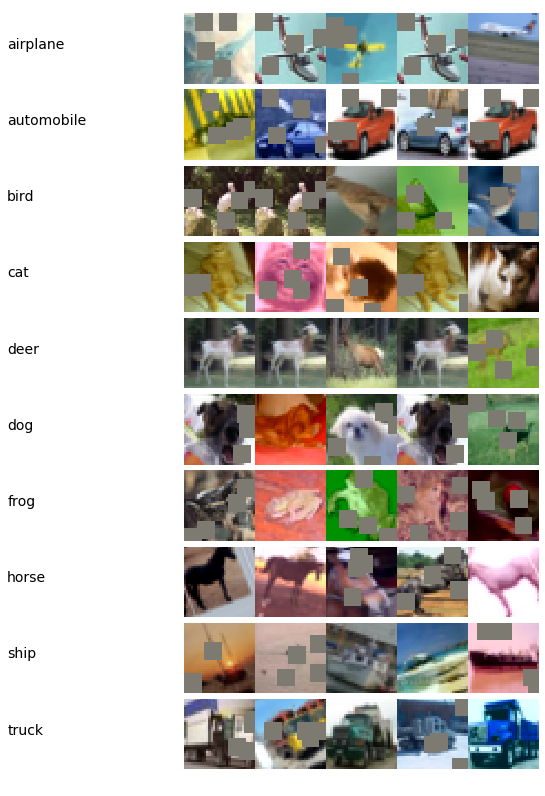

In [8]:
from __future__ import print_function

# As you can see that we have already normalized our data in the above code hence in order to view the data as it was given to us
# we need to unnormalize the data firstly.

def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline


import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10

# display 5 images from each category. 

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

# Model and Summary.

In [9]:
from Collected_Models import Resnet_Model
import torch

model = Resnet_Model.ResNet18()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

# Finding the best Learning Rate

In [10]:
!pip install torch-lr-finder -v --global-option= " amp "

Config variable 'Py_DEBUG' is unset, Python ABI tag may be incorrect
Config variable 'WITH_PYMALLOC' is unset, Python ABI tag may be incorrect
Created temporary directory: C:\Users\RASHUT~1\AppData\Local\Temp\pip-ephem-wheel-cache-ynqiap2w
Created temporary directory: C:\Users\RASHUT~1\AppData\Local\Temp\pip-req-tracker-o54jlohq
Created requirements tracker 'C:\\Users\\RASHUT~1\\AppData\\Local\\Temp\\pip-req-tracker-o54jlohq'
Created temporary directory: C:\Users\RASHUT~1\AppData\Local\Temp\pip-install-u00v6rgj
  1 location(s) to search for versions of torch-lr-finder:
  * https://pypi.org/simple/torch-lr-finder/
  Getting page https://pypi.org/simple/torch-lr-finder/
  Looking up "https://pypi.org/simple/torch-lr-finder/" in the cache
  Request header has "max_age" as 0, cache bypassed
  Starting new HTTPS connection (1): pypi.org:443
  https://pypi.org:443 "GET /simple/torch-lr-finder/ HTTP/1.1" 304 0
  Analyzing links from page https://pypi.org/simple/torch-lr-finder/
    Found link

    Found link https://files.pythonhosted.org/packages/1a/cb/9bab4fdd2d8f1d2aacc7cf2d20ad84fa4196d276b3a494960787453b31e9/AMP-1.1.4.tar.gz#sha256=5554285386d3414b129a62ee1615c4008d6a1738b328d9bab002576efeaffc34 (from https://pypi.org/simple/amp/), version: 1.1.4
  Using version 1.1.4 (newest of versions: 1.0.0.0, 1.1, 1.1.1, 1.1.2, 1.1.3, 1.1.4)
  Created temporary directory: C:\Users\RASHUT~1\AppData\Local\Temp\pip-unpack-at1ne01k
  Looking up "https://files.pythonhosted.org/packages/1a/cb/9bab4fdd2d8f1d2aacc7cf2d20ad84fa4196d276b3a494960787453b31e9/AMP-1.1.4.tar.gz" in the cache
  Current age based on date: 13975
  Ignoring unknown cache-control directive: immutable
  Freshness lifetime from max-age: 365000000
  The response is "fresh", returning cached response
  365000000 > 13975
  Using cached https://files.pythonhosted.org/packages/1a/cb/9bab4fdd2d8f1d2aacc7cf2d20ad84fa4196d276b3a494960787453b31e9/AMP-1.1.4.tar.gz
  Added amp from https://files.pythonhosted.org/packages/1a/cb/9ba

    Found link https://files.pythonhosted.org/packages/c2/24/2164463152fafd6cbb60cb3b42110418deeeaeef504bf81c3fec46f781fe/Django-1.3.6.tar.gz#sha256=df0121a4f90795e1b2a374b4df50219df1db203e7960de5e33a6ce31af17878a (from https://pypi.org/simple/django/), version: 1.3.6
    Found link https://files.pythonhosted.org/packages/0d/f1/fe4cf23cea3322dd8883a0510538fe916ab2023c648997976798142603ff/Django-1.3.7.tar.gz#sha256=ee50f44744e7238cb45429e4121d643c9e9201f9a63aaf646619bad18547fb8a (from https://pypi.org/simple/django/), version: 1.3.7
    Found link https://files.pythonhosted.org/packages/9a/f8/2a7b9922817be07d53c664a7702fab70e99899466b5956131a70c08606b6/Django-1.4.tar.gz#sha256=c096bafbea10e7d359bc15eb00a9bf11dbf5201a16d62acfa2de61d5a35488e9 (from https://pypi.org/simple/django/), version: 1.4
    Found link https://files.pythonhosted.org/packages/e6/3f/f3e67d9c2572765ffe4268fc7f9997ce3b02e78fd144733f337d72dabb12/Django-1.4.1.tar.gz#sha256=4d8d20eba350d3d29613cc5a6302d5c23730c7f9e150985b

    Found link https://files.pythonhosted.org/packages/b2/ef/d37cd67c9eccd7329ce421382f517bb6f9a431ded3c6fd60cba8c966712a/Django-1.5.4.tar.gz#sha256=428defe3fd515dfc8613039bb0a80622a13fb4b988c5be48db07ec098ea1704e (from https://pypi.org/simple/django/), version: 1.5.4
    Found link https://files.pythonhosted.org/packages/38/49/93511c5d3367b6b21fc2995a0e53399721afc15e4cd6eb57be879ae13ad4/Django-1.5.5.tar.gz#sha256=6ae69c1dfbfc9d0c44ae80e2fbe48e59bbbbb70e8df66ad2b7029bd39947d71d (from https://pypi.org/simple/django/), version: 1.5.5
    Found link https://files.pythonhosted.org/packages/b2/e5/78f1e96e8d3ae38cd9b3a4690a448a4716be73f5f5408d9f0da84576e36e/Django-1.5.6.tar.gz#sha256=9b7fcb99d20289189ec0f1e06d1d2bed3b4772e3a393fddbfb006ea7c3f9bfaf (from https://pypi.org/simple/django/), version: 1.5.6
    Found link https://files.pythonhosted.org/packages/56/13/32b4ad8b2bc3b9d820467dc30d28a53823314bcfcdfff55c0218dd4e5b08/Django-1.5.7.tar.gz#sha256=08a41c2a37451b8cc1136823b802dd6f17ad6ec0c8d2

    Skipping link https://files.pythonhosted.org/packages/c7/cb/1b2eb81a62f81e862c90675915dd07375d459d789ef372198abec9fbdc7a/Django-1.6.9-py2.py3-none-any.whl#sha256=20dd4ae31564df143fe8ca6daf507b68e32f3ef70987049fdb978023a843431c (from https://pypi.org/simple/django/); No binaries permitted for Django
    Found link https://files.pythonhosted.org/packages/de/c0/b9e7fbf78afb964a7ff7e9609ea7d4c65fb67c7c4d456638dfa45c3f8d0c/Django-1.6.9.tar.gz#sha256=d8c182e9ac88f6ef7e5f89e71282793d9682e76a8da39a0c4bfd452e611a06a8 (from https://pypi.org/simple/django/), version: 1.6.9
    Skipping link https://files.pythonhosted.org/packages/5c/50/f3eb71c2eee5abbfa4f9368ac0ccdf4d58dcc1d391d60cf9d8eb7070d52d/Django-1.6.10-py2.py3-none-any.whl#sha256=ceee83ff4c4fa1461289fe07a5879e8440089fadde150d40753691cdd8c942c1 (from https://pypi.org/simple/django/); No binaries permitted for Django
    Found link https://files.pythonhosted.org/packages/ff/83/fad3cc3ac64f8096ae5e56fa1de303ff947fb3fab69cd96d3df9ccf353fb/

    Skipping link https://files.pythonhosted.org/packages/cd/1a/9797706779fc77317887bcf4b12632c24aed8404b694ed1b8d1f7053c92b/Django-1.7.11-py2.py3-none-any.whl#sha256=100164556897c1219f33706e63a656b8848d33d09b0161e2deefcc50978cf62d (from https://pypi.org/simple/django/); No binaries permitted for Django
    Found link https://files.pythonhosted.org/packages/53/2a/cca393c0d65813f9f8e4d41e4a4d7d64fe8a6bd6dd7276583e2b6653af61/Django-1.7.11.tar.gz#sha256=2039144fce8f1b603d03fa5a5643578df1ad007c4ed41a617f02a3943f7059a1 (from https://pypi.org/simple/django/), version: 1.7.11
    Skipping link https://files.pythonhosted.org/packages/92/e7/95566ef630009a2b21fb1f0815287aa291be8756eb822f6f29a80cdd6084/Django-1.8a1-py2.py3-none-any.whl#sha256=ecca07bdf863444f955160a822fe3c979e3c64e1eb1d9553a4ba03c2af8864f2 (from https://pypi.org/simple/django/); No binaries permitted for Django
    Skipping link https://files.pythonhosted.org/packages/76/d4/a489819b66706406c07819844bae3f7d9613104c1581af2a4ef567e6

    Skipping link https://files.pythonhosted.org/packages/b8/c2/e162862650c30999ab39e05c7b12794d3f80e6b5a99c786419eddbb28fa3/Django-1.8.11-py2.py3-none-any.whl#sha256=54be9d6eab6cc0e2da558c12aea6cff7d5a0124c8a470e1ff61134ba9ed37f20 (from https://pypi.org/simple/django/); No binaries permitted for Django
    Found link https://files.pythonhosted.org/packages/92/41/46db17c36b6eaab3dbf600f094b2e3643f96c78d2cfcbeb4fe97d27ce03e/Django-1.8.11.tar.gz#sha256=ec148be73548da090dd76c2e8c57c98e8b1e84f2cb87500b9be5420187a435fb (from https://pypi.org/simple/django/), version: 1.8.11
    Skipping link https://files.pythonhosted.org/packages/d5/0d/445186a82bbcc75166a507eff586df683c73641e7d6bb7424a44426dca71/Django-1.8.12-py2.py3-none-any.whl#sha256=9c60c4af02faffb6f1c2bc7c7a09169c59230fa06c30a552414b816ee79f0c2a (from https://pypi.org/simple/django/); No binaries permitted for Django
    Found link https://files.pythonhosted.org/packages/c6/a2/3e3870966c64a46e0d974d4a40eb60f921a7cbb195d38ff00328899dcc

    Skipping link https://files.pythonhosted.org/packages/f9/22/2ecdc946394c2490212691bd44fc8b54aa6b1c49e8cb505d853dc0716646/Django-1.9.3-py2.py3-none-any.whl#sha256=0d4754d674be02b6e520633b4068d7917abedeabf7481994d4fb9870a5c8781c (from https://pypi.org/simple/django/); No binaries permitted for Django
    Found link https://files.pythonhosted.org/packages/31/6d/853c0006643daedfd4d1bd15ad3afcf3311ee3c0c55bc19572ae1cec52d5/Django-1.9.3.tar.gz#sha256=05191a2487de2726d3a964176cb0ffd7cbc071ad117fe06263b7932b96243b56 (from https://pypi.org/simple/django/), version: 1.9.3
    Skipping link https://files.pythonhosted.org/packages/36/13/87a668592e133d402ac6f9d07da7fea82e8b217e350a70c7ff53408cd93f/Django-1.9.4-py2.py3-none-any.whl#sha256=af6264550f8d1cc468db6bbd38151e539b0468ecc5d7d39598af918eae2428b2 (from https://pypi.org/simple/django/); No binaries permitted for Django
    Found link https://files.pythonhosted.org/packages/b0/9b/fbe58870d98321b08043cae62b6062552c5dc7515a2b43958c7330090ef3/D

    Skipping link https://files.pythonhosted.org/packages/4b/4c/059f68d8f029f7054e4e6bb0b1ed2fde7f28d07a3727325727d5a95ae1b8/Django-1.10-py2.py3-none-any.whl#sha256=9c60f4a801bf7c26bd6824c1062550c12c373344116703461c18cc258f8c9320 (from https://pypi.org/simple/django/); No binaries permitted for Django
    Found link https://files.pythonhosted.org/packages/18/5c/3cd8989b2226c55a1faf66f1a110e76cba6e6ca5d9dd15fb469fb636f378/Django-1.10.tar.gz#sha256=46b868d68e5fd69dd9e05a0a7900df91786097e30b2aa6f065dd7fa3b22f7005 (from https://pypi.org/simple/django/), version: 1.10
    Skipping link https://files.pythonhosted.org/packages/6c/cf/d6ab0edb891865ef86b3e3d7290c162f57c363cf880099bbe94229806f56/Django-1.10.1-py2.py3-none-any.whl#sha256=3d689905cd0635bbb33b87f9a5df7ca70a3db206faae4ec58cda5e7f5f47050d (from https://pypi.org/simple/django/); No binaries permitted for Django
    Found link https://files.pythonhosted.org/packages/0a/9e/e76cca958089cd0317ab46cb91f0ed36274900e48829c949b2e33d2a4469/Dja

    Skipping link https://files.pythonhosted.org/packages/fe/ca/a7b35a0f5088f26b1ef3c7add57161a7d387a4cbd30db01c1091aa87e207/Django-1.11.3-py2.py3-none-any.whl#sha256=c69e0c0416f2376b677830304d4c5fa8793b9c815af77be659a3c50d1f46c2e6 (from https://pypi.org/simple/django/); No binaries permitted for Django
    Found link https://files.pythonhosted.org/packages/45/23/a5dbb0cfee731549032034d2666cabba47a447f811f706cff82fd1947efc/Django-1.11.3.tar.gz#sha256=9ef9de0a957245ed3a29c4162ed2fd493252ca249a755f9e2b4a9be82caf8f6b (from https://pypi.org/simple/django/), version: 1.11.3
    Skipping link https://files.pythonhosted.org/packages/fc/fb/01e0084061c50f1160c2db5565ff1c3d8d76f2a76f67cd282835ee64e04a/Django-1.11.4-py2.py3-none-any.whl#sha256=6fd30e05dc9af265f7d7d10cfb0efa013e6236db0853c9f47c74c585587c5a57 (from https://pypi.org/simple/django/); No binaries permitted for Django
    Found link https://files.pythonhosted.org/packages/ce/a0/3f59e798179b23f813250c79ee31a346aeecd4fa09ae05b639647086f5

    Skipping link https://files.pythonhosted.org/packages/09/2b/6c2d363e3d46307251a9d6bf74ec28543805bbcadf56ca729f4a04846914/Django-1.11.17-py2.py3-none-any.whl#sha256=f1a961b954d96bb24b397db4c35e9a128d12e044d6b57984c122282b592d508d (from https://pypi.org/simple/django/); No binaries permitted for Django
    Found link https://files.pythonhosted.org/packages/a3/60/9d004f544297259b9467a1429e48d1fe1bda990aeb80744afaccb34aab4a/Django-1.11.17.tar.gz#sha256=a787ee66f4b4cf8ed753661cabcec603989677fa3a107fcb7f15511a44bdb483 (from https://pypi.org/simple/django/), version: 1.11.17
    Skipping link https://files.pythonhosted.org/packages/e0/eb/6dc122c6d0a82263bd26bebae3cdbafeb99a7281aa1dae57ca1f645a9872/Django-1.11.18-py2.py3-none-any.whl#sha256=7ee7d93d407f082e3849c8d10da50ff5b488af37ed1b0066a22dee5f2709ed16 (from https://pypi.org/simple/django/); No binaries permitted for Django
    Found link https://files.pythonhosted.org/packages/90/84/7981bdfcfa80fe81df5325899f9fc1cbebce1fbe4fac092a32dca0

    Skipping link https://files.pythonhosted.org/packages/44/98/35b935a98a17e9a188efc2d53fc51ae0c8bf498a77bc224f9321ae5d111c/Django-2.0-py3-none-any.whl#sha256=af18618ce3291be5092893d8522fe3919661bf3a1fb60e3858ae74865a4f07c2 (from https://pypi.org/simple/django/) (requires-python:>=3.4); No binaries permitted for Django
    Found link https://files.pythonhosted.org/packages/87/9f/4ec8b197d83666fddd2398842024c5341ee7d40bbec6aee9705d1ad22f13/Django-2.0.tar.gz#sha256=9614851d4a7ff8cbd32b73c6076441f377c45a5bbff7e771798fb02c43c31f47 (from https://pypi.org/simple/django/) (requires-python:>=3.4), version: 2.0
    Skipping link https://files.pythonhosted.org/packages/21/2a/3a0ec97b18d6e8d295142228f03604ac78ea6de05cf9bc3773a74f0b58bb/Django-2.0.1-py3-none-any.whl#sha256=52475f607c92035d4ac8fee284f56213065a4a6b25ed43f7e39df0e576e69e9f (from https://pypi.org/simple/django/) (requires-python:>=3.4); No binaries permitted for Django
    Found link https://files.pythonhosted.org/packages/54/6c/b751

    Skipping link https://files.pythonhosted.org/packages/63/72/d779f069acda9f5ce7aedca90a1410bfce03721e60c156472c95222cc1b7/Django-2.1a1-py3-none-any.whl#sha256=89ac9fce84db947da7e5d1e7a24eabd21216c04cc4386c93197f0aa2487e9945 (from https://pypi.org/simple/django/) (requires-python:>=3.5); No binaries permitted for Django
    Skipping link https://files.pythonhosted.org/packages/91/19/0e6f1e9e78d91cdb6fa6e326c24f7d765640f59888c982efdfcbb410146d/Django-2.1b1-py3-none-any.whl#sha256=21b35f96f3d84eae6a6f582156bacee1fd05badfa692da90cef48d9512e39e16 (from https://pypi.org/simple/django/) (requires-python:>=3.5); No binaries permitted for Django
    Skipping link https://files.pythonhosted.org/packages/50/3d/bafe9b26f71cac7fa52621cdd43ce78ceca1798fd3c4aa8bfd4f680ec653/Django-2.1rc1-py3-none-any.whl#sha256=486f8c08fd8fcb44c66e5d6d4a845a28831b3f5be1bbd4dcc245938ed55cdff1 (from https://pypi.org/simple/django/) (requires-python:>=3.5); No binaries permitted for Django
    Skipping link https://f

    Found link https://files.pythonhosted.org/packages/a3/e4/a7399d5c9044fc2cf1c27884865ee0e9ee3e02a775628f9f29f43f657baa/Django-2.1.12.tar.gz#sha256=f4351f1f921bb6c3de03e24cdba823365fb9a79a44f607ba2560e9e3b7f16ff3 (from https://pypi.org/simple/django/) (requires-python:>=3.5), version: 2.1.12
    Skipping link https://files.pythonhosted.org/packages/c4/e1/9c31da650533111ec044c2e540be72287d87c7b0ddb076640f943d900f98/Django-2.1.13-py3-none-any.whl#sha256=79c6cfbc76a4612efc8a80d0094b96f50cb2aa654b2b2b530a4e707fa2985b4b (from https://pypi.org/simple/django/) (requires-python:>=3.5); No binaries permitted for Django
    Found link https://files.pythonhosted.org/packages/ca/d6/940c06d14c5b60e32cce5f47143d4c944e93690dedbaa52b48a2f4f4ece9/Django-2.1.13.tar.gz#sha256=7a28a4eb0167eba491ccfafd7006843b5cdd26d8c93b955a74c2ea74f94efc2c (from https://pypi.org/simple/django/) (requires-python:>=3.5), version: 2.1.13
    Skipping link https://files.pythonhosted.org/packages/cd/53/5b415cf77c091e0011b0c

    Found link https://files.pythonhosted.org/packages/c7/2c/bbd0fddf6a08456c3100b8e8b230f3288d4511985aa4e2368b0d115b5aae/Django-2.2.6.tar.gz#sha256=a8ca1033acac9f33995eb2209a6bf18a4681c3e5269a878e9a7e0b7384ed1ca3 (from https://pypi.org/simple/django/) (requires-python:>=3.5), version: 2.2.6
    Skipping link https://files.pythonhosted.org/packages/a0/36/463632a2e9161a7e713488d719a280e8cb0c7e3a66ed32a32e801891caae/Django-2.2.7-py3-none-any.whl#sha256=89c2007ca4fa5b351a51a279eccff298520783b713bf28efb89dfb81c80ea49b (from https://pypi.org/simple/django/) (requires-python:>=3.5); No binaries permitted for Django
    Found link https://files.pythonhosted.org/packages/0d/05/5de305261e0a6bcd5701e2bfb5237e76303fde36f1f7c5a40ff86480ab5a/Django-2.2.7.tar.gz#sha256=16040e1288c6c9f68c6da2fe75ebde83c0a158f6f5d54f4c5177b0c1478c5b86 (from https://pypi.org/simple/django/) (requires-python:>=3.5), version: 2.2.7
    Skipping link https://files.pythonhosted.org/packages/d3/d0/ef75c788627f4218a8d08dccdf

    Found link https://files.pythonhosted.org/packages/3d/21/316d435bf8bd6f355be6b5765da91394fb38f405e5bea6680e411e4d470c/Django-3.0.3.tar.gz#sha256=2f1ba1db8648484dd5c238fb62504777b7ad090c81c5f1fd8d5eb5ec21b5f283 (from https://pypi.org/simple/django/) (requires-python:>=3.6), version: 3.0.3
    Skipping link https://files.pythonhosted.org/packages/12/68/8c125da33aaf0942add5095a7a2a8e064b3812d598e9fb5aca9957872d71/Django-3.0.4-py3-none-any.whl#sha256=89e451bfbb815280b137e33e454ddd56481fdaa6334054e6e031041ee1eda360 (from https://pypi.org/simple/django/) (requires-python:>=3.6); No binaries permitted for Django
    Found link https://files.pythonhosted.org/packages/1d/38/89ea18b5aeb9b56fff7430388946e8e9dfd7a451f3e6ddb8a9b637f442c1/Django-3.0.4.tar.gz#sha256=50b781f6cbeb98f673aa76ed8e572a019a45e52bdd4ad09001072dfd91ab07c8 (from https://pypi.org/simple/django/) (requires-python:>=3.6), version: 3.0.4
    Skipping link https://files.pythonhosted.org/packages/a9/4f/8a247eee2958529a6a805d38fb

    Found link https://files.pythonhosted.org/packages/45/c1/36e7b69e32fb900b8ade05ec2967bab73e0452dcf9eeabc9ef315b275f92/caldav-0.1.6.tar.gz#sha256=4a3b1855000feb8023ab05f8c9e0cfa1648a9abab9ca65ad3e933c22bab61310 (from https://pypi.org/simple/caldav/), version: 0.1.6
    Found link https://files.pythonhosted.org/packages/a9/1a/d1756840b9ff9ff260d915c75e7c685eff66cf1bcc3785e30dea72a57209/caldav-0.1.7.tar.gz#sha256=19916735dbe8c0d72dcc311ab660e4b60aa96368aaedbeafc64b2ac663db2d05 (from https://pypi.org/simple/caldav/), version: 0.1.7
    Found link https://files.pythonhosted.org/packages/5f/85/ee2cd6e5bb12832cbcef6b35660fbec9af78b5c67d5be6191773f3877855/caldav-0.1.8.tar.gz#sha256=62a14cd8a13481fd2a610a2bcaa064313d5691b204681185641e2dfded4353ed (from https://pypi.org/simple/caldav/), version: 0.1.8
    Found link https://files.pythonhosted.org/packages/63/33/40700c5dd73f76655d0fc7810c1194217ef84bf058f78d9098f68bea8d16/caldav-0.1.9.tar.gz#sha256=315e9e61fe99dbb4ab6e9e8738113f116aef249bb79f

  * https://pypi.org/simple/asgiref/
  Getting page https://pypi.org/simple/asgiref/
  Looking up "https://pypi.org/simple/asgiref/" in the cache
  Request header has "max_age" as 0, cache bypassed
  https://pypi.org:443 "GET /simple/asgiref/ HTTP/1.1" 304 0
  Analyzing links from page https://pypi.org/simple/asgiref/
    Found link https://files.pythonhosted.org/packages/c0/c6/56e967493d35d7baf033b60c133e847832c659e5018fc9aeda892fb60945/asgiref-0.8.tar.gz#sha256=ba30a973c12b58b5e7cc254af0f781dffbe9bfbcf3a73bec6ffac17c5ac4190c (from https://pypi.org/simple/asgiref/), version: 0.8
    Found link https://files.pythonhosted.org/packages/64/6e/dca52fec3e4b906e9b8c9dbd5de50b2f516f810f6401d828692cccc03345/asgiref-0.9.tar.gz#sha256=7df6d9dd26ab295063b8a911bc0f24b48bb55dfcc62e0fd579b1f92a77ad91d0 (from https://pypi.org/simple/asgiref/), version: 0.9
    Found link https://files.pythonhosted.org/packages/54/33/f2f8b993f64f67859a46494dc39b8886fa193b03a833840c2baf4201f34c/asgiref-0.9.1.tar.gz#sha

    Found link https://files.pythonhosted.org/packages/29/4c/9c6a071704413189f92374e635314e8a2ae5f72047c86fff79efa4e3c3f9/asgiref-1.1.0.tar.gz#sha256=fb251d65f15e95f14e706592480f6aad4c4dba6b48b9f8ad12b5b13cdd0f1397 (from https://pypi.org/simple/asgiref/), version: 1.1.0
    Skipping link https://files.pythonhosted.org/packages/a6/e9/55c236797474fc534863ca4da2cca75a708c718d80b811266450c0cfa182/asgiref-1.1.1-py2.py3-none-any.whl#sha256=aaf199524607300b7e3489bc0b3ca9391d9e055c7fd7bcb60147f46aa2742450 (from https://pypi.org/simple/asgiref/); No binaries permitted for asgiref
    Found link https://files.pythonhosted.org/packages/0d/e7/9fc51765849c89d1ddc7528ec06659dba460a7bf7de1e7b37d685b532fcd/asgiref-1.1.1.tar.gz#sha256=3aabdc84b483172191536d08f51fccb69556ab8875cfb23a448fdba9bded5e3d (from https://pypi.org/simple/asgiref/), version: 1.1.1
    Skipping link https://files.pythonhosted.org/packages/ee/6d/67f79a9567de5ba4419c3e8d39622bed0d974d704075d09df765b5ddb5ce/asgiref-1.1.2-py2.py3-none

    Found link https://files.pythonhosted.org/packages/9c/59/8afdd7e9c1e2b4b3a8aa716b579d39470f9afad23b69ab072ed7b5f6086d/asgiref-2.3.1.tar.gz#sha256=a77d0d5c8914ca3fbb396be7fda238bf479207cee77d6075dd7474cfeff821a4 (from https://pypi.org/simple/asgiref/), version: 2.3.1
    Skipping link https://files.pythonhosted.org/packages/6a/ca/c141dc77da60230e393d33b5b29afbca718b7e6ce07921c42cf08af907f8/asgiref-2.3.2-py2.py3-none-any.whl#sha256=9b05dcd41a6a89ca8c6e7f7e4089c3f3e76b5af60aebb81ae6d455ad81989c97 (from https://pypi.org/simple/asgiref/); No binaries permitted for asgiref
    Found link https://files.pythonhosted.org/packages/2c/0d/a569ab76f6dcec1f1c9946c3ed1e65bb1aa853e620c7626729e1f84b9b2d/asgiref-2.3.2.tar.gz#sha256=b21dc4c43d7aba5a844f4c48b8f49d56277bc34937fd9f9cb93ec97fde7e3082 (from https://pypi.org/simple/asgiref/), version: 2.3.2
    Skipping link https://files.pythonhosted.org/packages/ed/ed/ab1178f0848145c86c2d7c54cfb12d3baf35d76237a2d5c60039c883d8a2/asgiref-3.0.0-py2.py3-none

    Skipping link https://files.pythonhosted.org/packages/e2/ea/37fac52810bfa225c867cd05766d80c12799f0a0d38a552dfe0ba7d02a90/asgiref-3.2.6-py2.py3-none-any.whl#sha256=9c65b42045910c159ad41fc33692a8a6e6e154d8d05244ea69a0cbc617edad31 (from https://pypi.org/simple/asgiref/) (requires-python:>=3.5); No binaries permitted for asgiref
    Found link https://files.pythonhosted.org/packages/8d/47/394c8a9c22354d6ebde1e0f485b1c62403eedee0851c73cf0efcf84fddb6/asgiref-3.2.6.tar.gz#sha256=63007b556233381c5f22ae4c7e4292c9f1b953dc8909ae8fd268f611dc23cbd0 (from https://pypi.org/simple/asgiref/) (requires-python:>=3.5), version: 3.2.6
    Skipping link https://files.pythonhosted.org/packages/68/00/25013f7310a56d17e1ab6fd885d5c1f216b7123b550d295c93f8e29d372a/asgiref-3.2.7-py2.py3-none-any.whl#sha256=9ca8b952a0a9afa61d30aa6d3d9b570bb3fd6bafcf7ec9e6bed43b936133db1c (from https://pypi.org/simple/asgiref/) (requires-python:>=3.5); No binaries permitted for asgiref
    Found link https://files.pythonhosted.o

    Skipping link https://files.pythonhosted.org/packages/34/df/09498d42d71e19e7a81b576bc12ba6e475a0b217ab340c1fdc1bcad9324e/vobject-0.4.7-py2.4.egg#sha256=852542020f9821591c746c0a68153c3c965dfea145e25eea3c72fac305e08bb0 (from https://pypi.org/simple/vobject/); unsupported archive format: .egg
    Found link https://files.pythonhosted.org/packages/43/20/686bda534f9fd414e2fe38e9df662343edbaeccd05ede637709688fd3150/vobject-0.4.7.tar.gz#sha256=bdd8d8f3c5e4e005fa41826bf4df534cbe1d011de99ad08a21408f210644cced (from https://pypi.org/simple/vobject/), version: 0.4.7
    Skipping link https://files.pythonhosted.org/packages/96/21/fdc1b1839e90e552cd7e872bb6cc07b8413f943077b584e2e973a23f848f/vobject-0.4.8-py2.4.egg#sha256=d05a123fe9bf7dd0fa1396e2e0499ba7064f84b5f524fccfdbcb9a67990e3308 (from https://pypi.org/simple/vobject/); unsupported archive format: .egg
    Found link https://files.pythonhosted.org/packages/2f/4c/27c1a7d302005dccfedef352171f50056981fb661be2be1e8ca616e55616/vobject-0.4.8.tar

    writing entry points to pip-egg-info\vobject.egg-info\entry_points.txt
    writing requirements to pip-egg-info\vobject.egg-info\requires.txt
    writing top-level names to pip-egg-info\vobject.egg-info\top_level.txt
    writing manifest file 'pip-egg-info\vobject.egg-info\SOURCES.txt'
    reading manifest file 'pip-egg-info\vobject.egg-info\SOURCES.txt'
    reading manifest template 'MANIFEST.in'
    writing manifest file 'pip-egg-info\vobject.egg-info\SOURCES.txt'
    C:\Users\RASHU TYAGI\Anaconda3\lib\distutils\dist.py:274: UserWarning: Unknown distribution option: 'bugtrack_url'
      warnings.warn(msg)
  Source in c:\users\rashut~1\appdata\local\temp\pip-install-u00v6rgj\vobject has version 0.9.6.1, which satisfies requirement vobject from https://files.pythonhosted.org/packages/da/ce/27c48c0e39cc69ffe7f6e3751734f6073539bf18a0cfe564e973a3709a52/vobject-0.9.6.1.tar.gz#sha256=96512aec74b90abb71f6b53898dd7fe47300cc940104c4f79148f0671f790101 (from caldav==0.1.4->amp)
  Removed vob

    Skipping link https://files.pythonhosted.org/packages/9b/48/d9a0d8fa60ec579bf8e03e8aa77f738e38a57c5c08c73a7487105374301c/coverage-3.1b1.win32-py3.1.exe#sha256=58cc1c3a5f132afbd30b9bec353ac9fb1c313d0cb4989e86bc8cbd0a3e573ca6 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Found link https://files.pythonhosted.org/packages/50/34/9ecc615c1142b7864f4883dc83f5cf335caf1fc4b6fcc6dbd91a1ebc0ae4/coverage-3.1.tar.gz#sha256=55b5711853e43ef32fe77d6da3c4e24bf3223a28d188186b05c30d5081426aea (from https://pypi.org/simple/coverage/), version: 3.1
    Skipping link https://files.pythonhosted.org/packages/00/80/aac1ba659b1d0c51e12e4ac2b1ef4a471d758b633a64e8221db13c9c00f4/coverage-3.1.win32-py2.3.exe#sha256=dde247a769af14a696fa33635fea8953eba235067fa8785b8023f09dd87028f1 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/89/72/8eff9418f019dc1b215b55412186403d49772868d6962a1e0be863e1f32c/co

    Skipping link https://files.pythonhosted.org/packages/aa/2c/806aec3b71a040a97de0e1df7cd27c7570b59981e3f0d617b9695d6fe4ce/coverage-3.2b4.win32-py2.4.exe#sha256=29ec3913486200113a0f77f18aaa140add4fbcc896a5a0fd8ae6cb595f6150f0 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/3e/7b/74f63efde1e63f38894a5aa7b227d8f0c704e9df2cd403e9a452e3270b1c/coverage-3.2b4.win32-py2.5.exe#sha256=634f09d48d67605ce964acb02e0856322ad5f1b0de3eb70697b4f75d123bf28f (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/89/07/b01515c8a8180a6ad007a0662f81f3b223742ab7c0f6d7f59281fb9a4eda/coverage-3.2b4.win32-py2.6.exe#sha256=775fc97ecb1617cc2c4af4b2f7b98efbc88c341b221e0db92c140f66e9c0c42e (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/87/8f/c90d74cefc28af1580de906c794

    Skipping link https://files.pythonhosted.org/packages/da/e4/ef0112b16f4f89eb9b612bc1dc5be0b14f70c3af1b08b816bef8ad99841e/coverage-3.3.1.win32-py2.5.exe#sha256=2adc7bd483f6cf7d2bc1886fb1272e14f2a28e17c85571197107b400ffd526af (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/10/ee/f876925d7e974753bd4f087ab7c41f716889b8c4d56c88cdfc4039887e81/coverage-3.3.1.win32-py2.6.exe#sha256=022a40da8e0aaf5688778bd9171d490a5a2ca0992cd7a4ce4f29485a4cd2fd2c (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/bc/83/e1e41898928a3040c3d55ab0315f6f0318027090db379069dd2f114f4031/coverage-3.3.1.win32-py3.1.exe#sha256=11c1e5b4faf4881bfafddfff0cc3d41b7828ea669f3409d930e7e5c8b8156174 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Found link https://files.pythonhosted.org/packages/11/77/19ee7e2f0d94a4889b231db1747d25

    Skipping link https://files.pythonhosted.org/packages/f4/a6/19f56c0acdb4325f750841486d5a66301155ac90e100aef2ecabd63c1216/coverage-3.4.win32-py2.5.exe#sha256=a38b0d1db4cff9bf867cc0d123193d33f0d93b26131a87850be789a7609a4fe1 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/a2/e8/3d99d16ed92304948b81ebb592b656bd0a7d77f6573e635b2834a830f5d7/coverage-3.4.win32-py2.6.exe#sha256=f2e8aecd1f670965df5631b49b656049541674c33adb293bef02146a2979d069 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/85/77/cd91d9c661dd03f980db961ec7053ce616e6bf235559ce2e4507f2d57335/coverage-3.4.win32-py2.7.exe#sha256=6949db581dc019ef172168a8f11a8763985c0b193912cc4817b6ae61d6cf3ec9 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/7d/27/10add27efda066f1f13ffac7676b8a3b4

    Skipping link https://files.pythonhosted.org/packages/7a/43/30b4d7968b9fad2d49ed7f816c64cbec9e69329e27d5c3e29db1c02b3b20/coverage-3.5.2b1.win32-py2.7.exe#sha256=aadd8fbac29f0d27a5d07f4ad96cef8ae6222bc77219e1dfe3c1186fd39cdcd4 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/30/da/2f57c4553f4a8fb51c118c2d21ea96ccf84f9e8745ac4823647ef8831b52/coverage-3.5.2b1.win32-py3.1.exe#sha256=4e9949bb5c20fed6830c7113dc9bf4b5b042173c5de28f39cbd1b600b49e5bc8 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/4c/8b/67fe6baa6b0848078b3920eadf8886a07e98d6e6cb69a003c768aa46fa88/coverage-3.5.2b1.win32-py3.2.exe#sha256=fcf61c5341d4b965331f2db8fc1b9ea17c389c26686fffe4ef770f5362a3203e (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Found link https://files.pythonhosted.org/packages/8b/47/14015cd3d695bb5aa4b8d100

    Skipping link https://files.pythonhosted.org/packages/bd/bf/4338144480032c90ef78d1be4f97e3d4f86f8a1731fe64f89d06834e6d3e/coverage-3.6b3.win32-py2.6.exe#sha256=6ae847a52e6f9bf7020707b2f2b2f3a196f3282e8ee6b5187a84f22fe37bcefc (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/48/ec/df7a69589ff3ccd36f8e55deee1004131f65979c1f8106a403d10db5ea88/coverage-3.6b3.win32-py2.7.exe#sha256=2de751ab3f18cb8a487de0be3f5f4d07bdb9e3e98b885589c097498773e1b6de (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/2e/7a/860a609338b6bea0e50aa6f56f76d16d4957520adfc2bbefdcc645b9d614/coverage-3.6b3.win32-py3.1.exe#sha256=7f2dd697b246c68c2cbb84e74288add0fdd47d5ff3aaecf3d17332866dd0e980 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/b4/a9/5dd121d9e665ba88b4f684f9991

    Skipping link https://files.pythonhosted.org/packages/b3/32/97e163af7a2b50902d18873263ce0b7e0ef506263c1e60ebab61953cf35a/coverage-3.7.1-cp33-none-win32.whl#sha256=778cf461acb1edd251877b21043d3e8089f1de8bee757103cd1124497aa2c4d2 (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/71/c8/a8396fed1571ffd1aea49582cd82ed42979d697fb33d6210db82394207f3/coverage-3.7.1-cp33-none-win_amd64.whl#sha256=3b50e09002e420eddee1816017c44d0cb08483e3e14d919641b377a7ec83f030 (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/91/c8/92600197fe4919cac3e7f856b4caa0c589855c6e5eed22f07fe7fd7b9de6/coverage-3.7.1-cp34-none-win32.whl#sha256=b4fc3047692cc6c47ba9cbf3ae6c1c42fbaef9ab86a62f78bf260eb993afa068 (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/7a/23/84c5a

    Skipping link https://files.pythonhosted.org/packages/47/ab/86aa828104be686ded69e77dd2bf595cd3300617e7b004a63f6a6b490b6c/coverage-4.0a5-py3.2-win-amd64.egg#sha256=7cbaed47fdb8ba50d722dfe7222bfc47525689fb14a32ae9dc8de8bd040fd944 (from https://pypi.org/simple/coverage/); unsupported archive format: .egg
    Skipping link https://files.pythonhosted.org/packages/e2/f2/aed31cb21a258e8fcd05c2ca1ffb3f0a9cf6ec8c8fdc609346f98db10259/coverage-4.0a5-py3.2-win32.egg#sha256=0cd828baa2369b6fe98e8eb3a009158593277c21bcc92439a175ad251533e8cf (from https://pypi.org/simple/coverage/); unsupported archive format: .egg
    Skipping link https://files.pythonhosted.org/packages/2e/57/ed3b265073701a7cd4e78050308113557c106b776bf1a283f0533c263525/coverage-4.0a5-py3.3-win-amd64.egg#sha256=01ee6e05e310a0e4df0c5c75570b2d5119729c2125e92a2221693f0ba21697bb (from https://pypi.org/simple/coverage/); unsupported archive format: .egg
    Skipping link https://files.pythonhosted.org/packages/3e/31/444913e556dc9e2e309

    Skipping link https://files.pythonhosted.org/packages/1e/27/a39166eb746171b910cf176219b3b015a5e5aa27ca4abe2b6ae73938986d/coverage-4.0a6-cp33-none-win32.whl#sha256=d423dc08938ac259ab7515564293a9bbfa8a5ec2e7d575d68fc2ba3a186f81ad (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/39/b4/8ea3f800b8372667409f03e5ce72dc191e9a27a3aef3393511d34fc6c377/coverage-4.0a6-cp33-none-win_amd64.whl#sha256=0e70eec8446480d444453220cbb5ad420042cf1e94032910c74a06646ce895cc (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/9e/14/967d9d289f6e97f9881fe322b8fbd976f274fb9e271560d3f4a729b2c45e/coverage-4.0a6-cp34-cp34m-macosx_10_10_x86_64.whl#sha256=de26704cdc7aeaa8825d7f240146b1505b4a78ecde231f7ff7b2dc51114c8d46 (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packa

    Skipping link https://files.pythonhosted.org/packages/bb/60/0069b261a3060f6ad354b72ac6a3f8f4ba34d4cad1d361c58d3339dbacc0/coverage-4.0a6.win32-py2.7.exe#sha256=9d7f36d87f3ecb8c8738ff452a02e79bbe98ee4fa96e3da131c35a6f66e004b7 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/42/58/aecdaa6aa855f363b9c9da9315bf8ea2167d6c1959c9e84923a21eb1cad1/coverage-4.0a6.win32-py3.3.exe#sha256=718192e86b13b718fa7a5e364e0f80cd06370f78fd1bb4bb6bf575cdf2d42934 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/ae/83/2b80249e6ca46839daa6adaf80208707015458ce60c9964cab8cb0f32415/coverage-4.0a6.win32-py3.4.exe#sha256=32650f6241d6205142b703cd319147a0c427edb826ffb898f8c272677c06887a (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/68/22/366c82f95c5845f588ddcaf2060

    Skipping link https://files.pythonhosted.org/packages/ed/db/77ab1ba5ee0593e606573202515f91d9fafcf37c126755ac7a372f6d4ff4/coverage-4.0b1.win32-py2.6.exe#sha256=ac20b65933f64786abd5510e7f67dd7937543d683d132873f894b315041ad7db (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/a3/5e/4404e6648ab5a792d500352292fa40230372faddc0faff9394801e0a330b/coverage-4.0b1.win32-py2.7.exe#sha256=8c1cdf3531c8a8357423182bf1f17a38527637a1d7fbdbcccaf6f496b4cfe145 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/02/bf/e50bcc8dbb62a2fd4b978415b2c87298e171430c2926dc5eca2b99c9fc37/coverage-4.0b1.win32-py3.3.exe#sha256=e586688b74356825f26aee94b83650361597f2dbb82273747d5d0feee9501ce4 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/f3/5a/749de045fc79afa831f6692e080

    Skipping link https://files.pythonhosted.org/packages/4b/1c/44a3738fe9c345960a32f536e58215dd3a335b9963bf99c9fce2aeeec978/coverage-4.0b2.win32-py2.6.exe#sha256=a6c14ef5a48f1ddbdc77e30d62d7e800f249bfb621c987b653191e609a222896 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/3d/5b/a331ddb657d2b3989e32d5928d85d142b496769fc1dd14e2e3698d5b1fe4/coverage-4.0b2.win32-py2.7.exe#sha256=d58825603dc5a23e50359001149a2d70305188e995d4750bc911cd9bcc346dc4 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/27/62/6c24d563eb0c6be3533d2c91083ef77e9ce69d129b0d44a9f31c719b2718/coverage-4.0b2.win32-py3.3.exe#sha256=36502f71757fa2c06b193493bc467e2bf3b6c05e2350dc8c4d0ad28f1666dded (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/aa/e8/1dfa5558d08d1db37bde52fb546

    Skipping link https://files.pythonhosted.org/packages/e4/b4/ec3bbdbfaedee82133bb1661289aa44c2a8f1f25a0329ea6e6d7e41d8c99/coverage-4.0b3.win32-py3.3.exe#sha256=700fa2f91c960bdaea697f08bba4b6c9d2d992ecd5a619f632dab541ca04c74e (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/c7/a8/80dd67f22384c5c7bfa08a75b3022127cb4059115c138eced56792ad88e5/coverage-4.0b3.win32-py3.4.exe#sha256=8c47b543e0325eb0657e8e014da6369d88f6517ac07792de2f9090ba90a411b3 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/27/93/aa3647bc806bea78d8bb1f7f4eac0080e48bbd603e34595de4c6fc3e5b9c/coverage-4.0b3.win32-py3.5.exe#sha256=23cd23a61661875f942118af9f11355912c5cf292b2da30b2fb054181ab36684 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Found link https://files.pythonhosted.org/packages/de/dc/3c8fb9d067044be205bbef5d296fc9

    Skipping link https://files.pythonhosted.org/packages/8c/73/6267c729f2ee63c1452a9a74553807893cb5c90e71cf64fcc4e4a127d7f1/coverage-4.0.win32-py2.7.exe#sha256=efa308f8c540d0a2e572f944ee421fb8a48208be264762cba0b79cb89a567b36 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/57/13/9989aea213f3dfe6fd7b1ef913faf5c08afa48159d52b9936c8df979e6fa/coverage-4.0.win32-py3.3.exe#sha256=340cd142fd711dd6d1444b9ebd95438d1165e1c6df4b13d8866e195599781bff (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/4c/a8/4c19ed6fb07d34e000daf944b3419b9210a93a60129704a12bdbfa3c9ba7/coverage-4.0.win32-py3.4.exe#sha256=7c7cbd905ec8fdf08d77a79dad250796e56453ae6126b7b5345e0f87c5e0da4c (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/ec/13/0b035b87a178da1f47f0510c096ffafe7

    Skipping link https://files.pythonhosted.org/packages/2e/af/510ab6b22abc95ff9ed61c732ff19fa5698caaf3f752b375d116d7d90b0f/coverage-4.0.1.win32-py2.6.exe#sha256=ffc71216dbd6af223185e928f1d7e4686a6e3ff7663e83440809b6aa6091ced0 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/33/33/d670cdb99932c3293b79f6678ab47da0af1665bbf573263846360a34e64c/coverage-4.0.1.win32-py2.7.exe#sha256=c33368f9a9ae695092d73ba892c5e30ae6d3b2a81150a8564062cda2487a1c50 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/33/fa/f75b9af142206c69c122e3fc0bd31252771e1c5dd013e8ba1a3b37d0e673/coverage-4.0.1.win32-py3.3.exe#sha256=3c0530df4cd0987aad5d73f431bda4f86d81621c18f414b3515f1a16f31e6d0e (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/57/4a/691622276aaf32005bfeac01709

    Skipping link https://files.pythonhosted.org/packages/92/d8/68d2dc2e7e7b37b8b42d03442b5cfae96160cff505d93daad965fb485c87/coverage-4.0.2.win-amd64-py3.5.exe#sha256=10e6532c89872e92008de37b99576e40467628b84467d0a79320dcd6748a4240 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/33/be/48e978d4c54a2a9e3b52eedb0b4ad4cf5463fbe221f56e966a1120ae6138/coverage-4.0.2.win32-py2.6.exe#sha256=6e28dab9e2cd6767e72482314fcb59640e824bb2abab33fd2b2339b507af5f8c (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/93/ee/2a71c9ed4960f19eb7aa6dfc98478d7fd007cdb017dd2d51df7b5635dcd5/coverage-4.0.2.win32-py2.7.exe#sha256=fb1eca8377d42bb7aa8373623bd1bad19c044becd7317ab6b11963716456869c (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/ba/3d/d28291c8bcd21cc4438169c

    Skipping link https://files.pythonhosted.org/packages/80/d9/42303cdb888d9913af5829aa6788f6f2d6237ed17a90ec9f62504412b3cd/coverage-4.0.3.win-amd64-py3.4.exe#sha256=ee2338539157cfc35fb1d6757dd799126804df39393c4a6c5fe88b402c8c0ab4 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/68/d4/6ae013c5daa4cbfffad9a63d385bf1726907aa1da423f51813db8e9643f8/coverage-4.0.3.win-amd64-py3.5.exe#sha256=2be3748f45d2eb0259c3c93abccc15c10725ef715bf0817a4c0a1a1dad2abc6a (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/69/9d/5f98a5f97685d86fc0dce424ce717f2469c5d08c39bc378d5bf6b2934e83/coverage-4.0.3.win32-py2.6.exe#sha256=af6ed80340e5e1b89fa794f730ce7597651fbda3312e500002688b679c184ef9 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/16/c4/131aee3fb0d35517b86

    Skipping link https://files.pythonhosted.org/packages/6a/6e/2d19830716402471febb416d19aa3b5dafc0e486d9e6931e07c132f7c18a/coverage-4.1b1.win-amd64-py3.3.exe#sha256=b4c3f691549b3a519248c1f8e180ead29723897326eb7b4d150829a4dde33227 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/e9/20/0feef0809947628a18a2388bde36330acd64309c37d7a16186c87bfc5b83/coverage-4.1b1.win-amd64-py3.4.exe#sha256=cf1bb081e123692fed2fc47077ff254171379fab460271b7486e409ae2350788 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/cd/ba/ec6fb3099ea958c33d12bd1a405e14fca76fa16f4d709b4870c100f9a285/coverage-4.1b1.win-amd64-py3.5.exe#sha256=1e170f5f668b5c3ed60c9208d6d6686caf1f68192360479bb344389d03b4cc58 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/7d/a6/a94511c0e23e230

    Skipping link https://files.pythonhosted.org/packages/64/eb/9125084a910908acb96ead0b0d36ba7f03cc7cf77b4468a553e0783f30b0/coverage-4.1b2.win-amd64-py2.6.exe#sha256=b3bcedfd567d68c2108e10c876e1ad670fc1217c0f0050748a164672630e497f (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/8c/f7/3e1820935c52380310b55689ee6963d98d0cd9969459906aaab870b20689/coverage-4.1b2.win-amd64-py2.7.exe#sha256=d7393623dcf5cc7ce67e3f27c95a7a52599c1dae4382266405898ab7b386bcc9 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/59/01/4e948fbd7d269ff0ea883119e88a3a2b85ecb15866f6eb9f97e78307d3e4/coverage-4.1b2.win-amd64-py3.3.exe#sha256=41772ba622c1467c674fe14730b81dafc3a50a6707a88c17dff89cca44ea2c70 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/93/cd/02cb1ca5bc01486

    Skipping link https://files.pythonhosted.org/packages/8a/b7/3a712af5441c810df4d55517050d221f5f2805961410bd23ebc1c4ffa69b/coverage-4.1b3-cp35-cp35m-win_amd64.whl#sha256=0b45a3fa4917b228031ecf16465203e37ecee48e155bb24b59c0980dd0f5ff52 (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Found link https://files.pythonhosted.org/packages/f3/f5/ae6ee2debf933c425e644160c2c9dc3f5c05d7cc66318b50e79396f1f900/coverage-4.1b3.tar.gz#sha256=29c43e1530e18f0a911ad5f80282d35fb4ce6f98624151b7ddc43e22885227d4 (from https://pypi.org/simple/coverage/), version: 4.1b3
    Skipping link https://files.pythonhosted.org/packages/6b/b5/b0ab4ddd0988b405dba445f5c57108b688c3379144c370fb799c865eedc2/coverage-4.1b3.win-amd64-py2.6.exe#sha256=aac57121f7a0f90b79c35c7f5442adf11bc7bb65fc4ce09009c251278eb6c0a1 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/2b/ee/3bd05122a5593ebdddfc2e3d90f5b2599ada29e9b1

    Skipping link https://files.pythonhosted.org/packages/84/2a/bdd63a1cca83076d5cea877cc4c8d1ceef6511bb44ea316cb21af87d6fe1/coverage-4.1-cp35-cp35m-macosx_10_10_x86_64.whl#sha256=faec03df1bd3d3ab2b85a226ed3942bfcd1682dbe4c91fcfa160e594861bf9b2 (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/47/a9/b8dead3820c46a17956777f225a0adfa1cc1054eb879d746e2bda2f7c329/coverage-4.1-cp35-cp35m-win32.whl#sha256=fb693f1638c0e5e077fd885730fb72410c774859ec625a921468021623f91b50 (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/9d/b0/eee2dd1670ab91af637cef87c4cbd6fceb8309e03fb0ff1a07bb877dfd16/coverage-4.1-cp35-cp35m-win_amd64.whl#sha256=e99df5724c775f36f171783874c989b48ccfc00d50b86bbdbaae96c5bee44cf7 (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/

    Skipping link https://files.pythonhosted.org/packages/d1/07/9348038b380f92f5d218b9092e85a7fa3d92129eeb1121fe07c3e938bcfc/coverage-4.2b1-cp34-cp34m-macosx_10_10_x86_64.whl#sha256=c7b562af0b3dcf7dacd162dff9b096efd18feb637deb36fd0a92df216d4c5f7a (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/cb/23/1a3fac71de75de6a3b624ff8134ed9005e8845b3b6910332aafebe08175a/coverage-4.2b1-cp34-cp34m-win32.whl#sha256=f233c1e3e1f1cc4157a2266ebc69858308d676869bfce24a70f503431ace90b0 (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/39/36/4888c6eb0fca018328ce4a4c6169c66be032c6ad75244f7bc618758e2f44/coverage-4.2b1-cp34-cp34m-win_amd64.whl#sha256=b064dd583e3488261985251feecc4bb343c9a625626b30e395cd5411396b5c7b (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/pac

    Skipping link https://files.pythonhosted.org/packages/55/fa/344c5319e6f82c3c36b8bc861f8f1d4d9992661ef870c8988f39bfd54fe0/coverage-4.2-cp33-cp33m-macosx_10_10_x86_64.whl#sha256=40092d2d24c8ecf3d3ffc84521f88a0fe140fa333a95422f194bd48b9de049f7 (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/a0/34/1185348cc5c541bbdf107438f0f0ea9df5d9a4233a974e9228b6ee815489/coverage-4.2-cp33-cp33m-win32.whl#sha256=38e87c46d364b8b3ac4d161586707345b7bc7b16855be1751345fc91be702ff7 (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/b1/55/02815cb8abb091033abb979ebde5122bb33b85c5987dede9ccd019033d19/coverage-4.2-cp33-cp33m-win_amd64.whl#sha256=bd4eba631f07cae8cdb9c55c144f165649e6701b962f9d604b4e00cf8802406c (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/

    Skipping link https://files.pythonhosted.org/packages/73/d6/09baa1bf639c1f8e56ac6b1539485e4f7c6c13a142f097bbd5cb8ccb1e83/coverage-4.3-cp27-cp27m-win32.whl#sha256=f91c4ad141c05b235ed2f69d22fc91365bc938a3fa0ea8bdd35118d6c796bf5a (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/cb/92/bf951a827d5f776058211306d0ac96b3d8837381585d54712cdd8e0ac2ce/coverage-4.3-cp27-cp27m-win_amd64.whl#sha256=bc419f3ff2a9f8e66c8d428af8eb8d9afecc52876469d34e9251ba9a8ce4f946 (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/d7/f2/8af252836af11299f8f99ea9a076404778aa2a37a543c8ef818323e5ef6e/coverage-4.3-cp33-cp33m-macosx_10_10_x86_64.whl#sha256=d47871e56e4fcca07a95d8a633afc9e71c001db3bb5b8d6ee9f0db995a956078 (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/

    Skipping link https://files.pythonhosted.org/packages/98/d7/9541d9f44d746635052d58a3869f57e3fc225f851313c15506eb7ffa3647/coverage-4.3.1-cp27-cp27m-macosx_10_10_intel.whl#sha256=2296613194adfb088c63696cbdaff1d75d22a01916febf624f3b5bd37940f638 (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/86/dd/167b4b9d5c5268a9eb5dcb5eee64816b26ef019c2d2cea9995164c0bc001/coverage-4.3.1-cp27-cp27m-macosx_10_10_x86_64.whl#sha256=f83917fde403fe02b9dd8fe3da04fe2f1ab6a7186cc30929c5d3cbe332f08166 (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/4e/8e/b46fb3559ac49d9ab0a657297720bf9110a60475b6c6b1adf31e1597c9b8/coverage-4.3.1-cp27-cp27m-win32.whl#sha256=fca45a15deaea4c16c44a3898afb11cf5cd8b94d289e88a642c5a59324938d0c (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhoste

    Skipping link https://files.pythonhosted.org/packages/8b/90/cfc3dc2449a4adf2cd48ce1555560e17e21b38a8f176eec3c5629453ca21/coverage-4.3.2-cp26-cp26m-win32.whl#sha256=209c2eb6ae504aabcdcbf8a886311cfa7dc579029f26a57be08adb3cc018417d (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/f5/99/2872b3539f38ca95c3db8dd9c43d5936356312c6e10aa1bbd8c61b98aa79/coverage-4.3.2-cp26-cp26m-win_amd64.whl#sha256=2b2a9967685f2ba3489207e1ddf72b069759e2a1498c5b9acd326ed86ed5180a (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/68/ca/81f3865f64b34b65ed0bab41485ae7b9c3d51a0302f261d4e6b941ed6258/coverage-4.3.2-cp27-cp27m-macosx_10_10_intel.whl#sha256=de55622ecdf856c2c487531beb344fc885523feddcbe8580c321c3de25f6e0aa (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/pack

    Skipping link https://files.pythonhosted.org/packages/c8/bd/d277f251a85493869192418d15a47f4422aa92f2c98dba61dcf5e5fa8554/coverage-4.3.2.win32-py3.6.exe#sha256=8b2ad578b9e16ddc1b3bb62cbbc26f520cfae13aa7ea4f63146ca00588e31958 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/93/de/df46b4c3f0bf9a6bfd96d942bf339ac306de6b68f522cfcc7ef632343c29/coverage-4.3.3-cp26-cp26m-macosx_10_10_x86_64.whl#sha256=014eab10fe3ad6003bf1fc5eac09dd7573cff0ebd8cf4de0c025ccce806fe757 (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/46/66/54b8587d01a091d7f0b0e27a5961048d9df4a33a29da26f53ade068117c4/coverage-4.3.3-cp26-cp26m-win32.whl#sha256=0484c61438c876bfc50205149f380ed2330b08f74227dbc098f2ccdcc4ae19c6 (from https://pypi.org/simple/coverage/); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/10/b5

    Skipping link https://files.pythonhosted.org/packages/01/6b/de9ab065f4527445e4f11273cc7185a373b3e01af360a9cbb1c4b112cd6e/coverage-4.3.3.win32-py3.4.exe#sha256=acf0ddf164ad84db8cfcb2843897d8f0347edb78e501d73514a571f8ea04f834 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/2d/53/ba345963af04bb2260eb59760294e3b52fbb1aabebee269ada945d53bddb/coverage-4.3.3.win32-py3.5.exe#sha256=e43dafe21413870ca10ab7b4ed80e73868ba4e392c003cc5b43813d478c0aa78 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/c2/8e/fbb46ed0679227e0a7fbe7b0bd2a8308cda735cc15a8d993bce38624f47a/coverage-4.3.3.win32-py3.6.exe#sha256=3f50865293ee3ec997fcb3ce41066ea3036350ae2ec7995467dd5793ef6f0077 (from https://pypi.org/simple/coverage/); unsupported archive format: .exe
    Skipping link https://files.pythonhosted.org/packages/4a/d6/42387450dda84ff553514ab3d48

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




    Skipping link https://files.pythonhosted.org/packages/9e/42/f9cc0dd32d01add63b7356ca78ffbc84344c0875634cc8203e7774c31a70/coverage-5.0-cp36-cp36m-win_amd64.whl#sha256=3be5338a2eb4ef03c57f20917e1d12a1fd10e3853fed060b6d6b677cb3745898 (from https://pypi.org/simple/coverage/) (requires-python:>=2.7, !=3.0.*, !=3.1.*, !=3.2.*, !=3.3.*, !=3.4.*, <4); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/57/c2/c2bebbdc27a3754b61ee45b4c70bf00863eb09663b9293f438d273718737/coverage-5.0-cp37-cp37m-macosx_10_13_x86_64.whl#sha256=79388ae29c896299b3567965dbcd93255f175c17c6c7bca38614d12718c47466 (from https://pypi.org/simple/coverage/) (requires-python:>=2.7, !=3.0.*, !=3.1.*, !=3.2.*, !=3.3.*, !=3.4.*, <4); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/cc/4e/225797f09218b6a332ef6fd5b4b18daae2e44841996a606c0dbc5b4dec79/coverage-5.0-cp37-cp37m-manylinux1_i686.whl#sha256=4a7f8e72b18f2aca288ff02255ce32cc830bc04d993

    Skipping link https://files.pythonhosted.org/packages/b8/f9/f91407b7d4e4c02b1c27b66d52cd7e58c9afcf8a527304aa63541a88e87b/coverage-5.0.1-cp27-cp27mu-manylinux1_x86_64.whl#sha256=25b8f60b5c7da71e64c18888f3067d5b6f1334b9681876b2fb41eea26de881ae (from https://pypi.org/simple/coverage/) (requires-python:>=2.7, !=3.0.*, !=3.1.*, !=3.2.*, !=3.3.*, !=3.4.*, <4); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/90/63/b156cfdcaf64d01c28137e0bdebf245f768c301a6ef3f3547315dcb15d21/coverage-5.0.1-cp35-cp35m-macosx_10_12_x86_64.whl#sha256=7362a7f829feda10c7265b553455de596b83d1623b3d436b6d3c51c688c57bf6 (from https://pypi.org/simple/coverage/) (requires-python:>=2.7, !=3.0.*, !=3.1.*, !=3.2.*, !=3.3.*, !=3.4.*, <4); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/71/eb/73a9a01ffdd424f0f8eb7224a940aaf95094dc584a8d2309bdf357541df3/coverage-5.0.1-cp35-cp35m-manylinux1_i686.whl#sha256=fcd4459fe35a400b8f416bc579068

    Skipping link https://files.pythonhosted.org/packages/83/a3/6f1d0fbdc5f69fce9656768f770a507eea28970eff158f6a4eca72bb7047/coverage-5.0.1-cp38-cp38m-win_amd64.whl#sha256=5f622f19abda4e934938e24f1d67599249abc201844933a6f01aaa8663094489 (from https://pypi.org/simple/coverage/) (requires-python:>=2.7, !=3.0.*, !=3.1.*, !=3.2.*, !=3.3.*, !=3.4.*, <4); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/a9/27/fe59a7c298e970d19141c494309682738a9f92531a520b56cfade1922373/coverage-5.0.1-cp39-cp39m-win32.whl#sha256=2714160a63da18aed9340c70ed514973971ee7e665e6b336917ff4cca81a25b1 (from https://pypi.org/simple/coverage/) (requires-python:>=2.7, !=3.0.*, !=3.1.*, !=3.2.*, !=3.3.*, !=3.4.*, <4); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/5a/79/0e09e17848dbb60def1e2407328bba94ddf7e25a07ecaa3916fc1186a9fa/coverage-5.0.1-cp39-cp39m-win_amd64.whl#sha256=b7dbc5e8c39ea3ad3db22715f1b5401cd698a621218680c6daf42c2f9d

    Skipping link https://files.pythonhosted.org/packages/06/77/2e947dadbdf9d3fb37af05f3ba9a246ff1161cde5e82f802b8d9ed7b832a/coverage-5.0.2-cp36-cp36m-win_amd64.whl#sha256=47874b4711c5aeb295c31b228a758ce3d096be83dc37bd56da48ed99efb8813b (from https://pypi.org/simple/coverage/) (requires-python:>=2.7, !=3.0.*, !=3.1.*, !=3.2.*, !=3.3.*, !=3.4.*, <4); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/b0/6f/831d8c193d854eb5d177809572de8d6df160e85e819e3cb9b1242e890a72/coverage-5.0.2-cp37-cp37m-macosx_10_13_x86_64.whl#sha256=955ec084f549128fa2702f0b2dc696392001d986b71acd8fd47424f28289a9c3 (from https://pypi.org/simple/coverage/) (requires-python:>=2.7, !=3.0.*, !=3.1.*, !=3.2.*, !=3.3.*, !=3.4.*, <4); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/b9/ae/87c676c135b2b7ad959a58806a34472207a4c5e33dc90ada38278ba9c894/coverage-5.0.2-cp37-cp37m-manylinux1_i686.whl#sha256=1f4ee8e2e4243971618bc16fcc447831740520

    Skipping link https://files.pythonhosted.org/packages/59/f6/e7d4ee535cc4ea5b60fd029d95a5d213cd3bf63f498b0339e530ab17b558/coverage-5.0.3-cp27-cp27mu-manylinux1_x86_64.whl#sha256=5012d3b8d5a500834783689a5d2292fe06ec75dc86ee1ccdad04b6f5bf231691 (from https://pypi.org/simple/coverage/) (requires-python:>=2.7, !=3.0.*, !=3.1.*, !=3.2.*, !=3.3.*, !=3.4.*, <4); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/1f/77/50e4834bba98bfbfc500b3ac461f3922dd235272a40d77f10dbcc25a7c40/coverage-5.0.3-cp35-cp35m-macosx_10_12_x86_64.whl#sha256=d513cc3db248e566e07a0da99c230aca3556d9b09ed02f420664e2da97eac301 (from https://pypi.org/simple/coverage/) (requires-python:>=2.7, !=3.0.*, !=3.1.*, !=3.2.*, !=3.3.*, !=3.4.*, <4); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/86/f6/9dd6324dd218390dc366d4c8f65b9359b006ffbb9090047c5d68a1b78fec/coverage-5.0.3-cp35-cp35m-manylinux1_i686.whl#sha256=3dbb72eaeea5763676a1a1efd9b42

    Skipping link https://files.pythonhosted.org/packages/6a/69/6f21ee32848b03203b3e7c2a6f2fe6827a90d06ebe92ba4a24ac0ed158f3/coverage-5.0.3-cp38-cp38m-win_amd64.whl#sha256=76e2057e8ffba5472fd28a3a010431fd9e928885ff480cb278877c6e9943cc2e (from https://pypi.org/simple/coverage/) (requires-python:>=2.7, !=3.0.*, !=3.1.*, !=3.2.*, !=3.3.*, !=3.4.*, <4); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/e5/75/6723fd4e7688bceb7c0f71db6b0905f9ef2f8fcb509d3272f7da5580ad77/coverage-5.0.3-cp39-cp39m-win32.whl#sha256=b63dd43f455ba878e5e9f80ba4f748c0a2156dde6e0e6e690310e24d6e8caf40 (from https://pypi.org/simple/coverage/) (requires-python:>=2.7, !=3.0.*, !=3.1.*, !=3.2.*, !=3.3.*, !=3.4.*, <4); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/ce/b7/61eb0518f19f3ae1ff2ba4813b6e35777a516afe6b1c506232a2c10da689/coverage-5.0.3-cp39-cp39m-win_amd64.whl#sha256=da93027835164b8223e8e5af2cf902a4c80ed93cb0909417234f4a9df3

    Skipping link https://files.pythonhosted.org/packages/e1/85/7696ef031314f5e8ca1bdd5e7b5696dfe603ef3c55d4e53d6f138d1f3bdc/coverage-5.0.4-cp36-cp36m-win_amd64.whl#sha256=0a907199566269e1cfa304325cc3b45c72ae341fbb3253ddde19fa820ded7a8b (from https://pypi.org/simple/coverage/) (requires-python:>=2.7, !=3.0.*, !=3.1.*, !=3.2.*, !=3.3.*, !=3.4.*, <4); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/cc/c9/f5c77b3385d2951ed6abd25f90e36eee056a5e2cd4fe7f93625c0024fcb8/coverage-5.0.4-cp37-cp37m-macosx_10_13_x86_64.whl#sha256=513e6526e0082c59a984448f4104c9bf346c2da9961779ede1fc458e8e8a1f78 (from https://pypi.org/simple/coverage/) (requires-python:>=2.7, !=3.0.*, !=3.1.*, !=3.2.*, !=3.3.*, !=3.4.*, <4); No binaries permitted for coverage
    Skipping link https://files.pythonhosted.org/packages/3d/01/5f2b587ecf1ba826951bdd895a940e3165d6383a92e79608bcd82ec58dec/coverage-5.0.4-cp37-cp37m-manylinux1_i686.whl#sha256=3844c3dab800ca8536f75ae89f3cf566848a3e

  Source in c:\users\rashut~1\appdata\local\temp\pip-install-u00v6rgj\coverage has version 5.0.4, which satisfies requirement coverage from https://files.pythonhosted.org/packages/d1/7d/ac53d7350a5178c1f59ddf0f17552bf68e4bb3a202543f9a30bbaa46cf80/coverage-5.0.4.tar.gz#sha256=1b60a95fc995649464e0cd48cecc8288bac5f4198f21d04b8229dc4097d76823 (from caldav==0.1.4->amp)
  Removed coverage from https://files.pythonhosted.org/packages/d1/7d/ac53d7350a5178c1f59ddf0f17552bf68e4bb3a202543f9a30bbaa46cf80/coverage-5.0.4.tar.gz#sha256=1b60a95fc995649464e0cd48cecc8288bac5f4198f21d04b8229dc4097d76823 (from caldav==0.1.4->amp) from build tracker 'C:\\Users\\RASHUT~1\\AppData\\Local\\Temp\\pip-req-tracker-o54jlohq'
Skipping bdist_wheel for torch-lr-finder, due to binaries being disabled for it.
Skipping bdist_wheel for amp, due to binaries being disabled for it.
Skipping bdist_wheel for Django, due to binaries being disabled for it.
Skipping bdist_wheel for caldav, due to binaries being disabled for it.

C:\Users\RASHU TYAGI\Anaconda3\lib\site-packages\pip\_internal\commands\install.py:207: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Command ""C:\Users\RASHU TYAGI\Anaconda3\python.exe" -u -c "import setuptools, tokenize;__file__='C:\\Users\\RASHUT~1\\AppData\\Local\\Temp\\pip-install-u00v6rgj\\torch-lr-finder\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))"  install --record C:\Users\RASHUT~1\AppData\Local\Temp\pip-record-osiw1z43\install-record.txt --single-version-externally-managed --compile" failed with error code 1 in C:\Users\RASHUT~1\AppData\Local\Temp\pip-install-u00v6rgj\torch-lr-finder\


### Using "Leslie Smith's" approach to find the best learning rate.

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


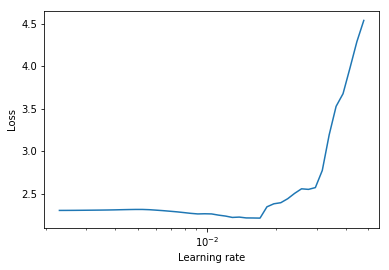

In [12]:
# source - https://github.com/davidtvs/pytorch-lr-finder

from Personalised_LR_Finder import LRFinder
import torch.optim as optim
import torch.nn as nn


#source - https://github.com/davidtvs/pytorch-lr-finder/blob/master/torch_lr_finder/lr_finder.py

L1lambda = 0
L2lambda = 1e-2
criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True, weight_decay=L2lambda)

#optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)

lr_finder = LRFinder(model, optimizer, criterion, device=model.device)

lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=1, num_iter=100, step_mode="exp")


# optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, nesterov=True, weight_decay=L2lambda)
# lr_finder = LRFinder(model, optimizer, criterion, device=model.device)
# lr_finder.range_test(train_loader, end_lr=100, num_iter=100)

lr_finder.plot() # to inspect the loss-learning rate graph

lr_finder.reset() # to reset the model and optimizer to their initial state

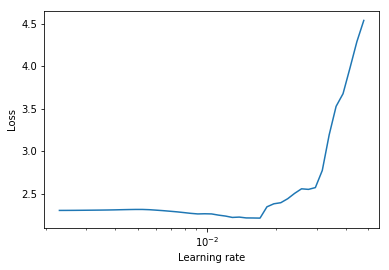

In [13]:
lr_finder.plot()

In [14]:
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
#lr[loss.index(min(loss))]
optimizer = optim.SGD(model.parameters(), lr=lr[loss.index(min(loss))], momentum=0.9, nesterov=True, weight_decay=L2lambda)

# Training and Testing our Model.

In [16]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
EPOCHS = 50

optimizer = optim.SGD(model.parameters(), lr=lr[loss.index(min(loss))], momentum=0.9, nesterov=True, weight_decay=L2lambda)

scheduler = ReduceLROnPlateau(optimizer, min_lr=1e-7,patience = 2,verbose=True)

L1lambda = 0

model.gotrain(optimizer, train_loader, test_loader, EPOCHS, r"C:\Users\RASHU TYAGI\EVA 4 Phase 1\Session 10", scheduler, False , L1lambda)

In scheduler step with loss of  1.212497693824768
Validation loss decreased (100000.000000 --> 1.212498).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0116, Accuracy: 46.45%; Test set: Average loss: 1.2125, Accuracy: 58.39%
Learning Rate = 0.016982


In scheduler step with loss of  1.027663965702057
Validation loss decreased (1.212498 --> 1.027664).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0084, Accuracy: 62.51%; Test set: Average loss: 1.0277, Accuracy: 63.56%
Learning Rate = 0.016982


In scheduler step with loss of  0.8947532738685607
Validation loss decreased (1.027664 --> 0.894753).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0076, Accuracy: 66.74%; Test set: Average loss: 0.8948, Accuracy: 69.26%
Learning Rate = 0.016982


In scheduler step with loss of  0.9112712677955628
Epoch: 4, Train set: Average loss: 0.0072, Accuracy: 68.75%; Test set: Average loss: 0.9113, Accuracy: 68.91%
Learning Rate = 0.016982


In scheduler step with loss of  0.9937565153121948
Epoch: 5, Train set: Average loss: 0.0071, Accuracy: 69.47%; Test set: Average loss: 0.9938, Accuracy: 66.58%
Learning Rate = 0.016982


In scheduler step with loss of  0.8292688239574433
Validation loss decreased (0.894753 --> 0.829269).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0069, Accuracy: 69.88%; Test set: Average loss: 0.8293, Accuracy: 71.54%
Learning Rate = 0.016982


In scheduler step with loss of  0.9166061386108398
Epoch: 7, Train set: Average loss: 0.0068, Accuracy: 70.56%; Test set: Average loss: 0.9166, Accuracy: 68.77%
Learning Rate = 0.016982


In scheduler step with loss of  0.8485624120712281
Epoch: 8, Train set: Average loss: 0.0067, Accuracy: 70.95%; Test set: Average loss: 0.8486, Accuracy: 70.68%
Learning Rate = 0.016982


In scheduler step with loss of  0.8645707504272461
Epoch     9: reducing learning rate of group 0 to 1.6982e-03.
Epoch: 9, Train set: Average loss: 0.0066, Accuracy: 71.33%; Test set: Average loss: 0.8646, Accuracy: 70.60%
Learning Rate = 0.001698


In scheduler step with loss of  0.4597298176765442
Validation loss decreased (0.829269 --> 0.459730).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0048, Accuracy: 79.91%; Test set: Average loss: 0.4597, Accuracy: 84.76%
Learning Rate = 0.001698


In scheduler step with loss of  0.40053199801445005
Validation loss decreased (0.459730 --> 0.400532).  Saving model ...
Epoch: 11, Train set: Average loss: 0.0043, Accuracy: 82.28%; Test set: Average loss: 0.4005, Accuracy: 86.79%
Learning Rate = 0.001698


In scheduler step with loss of  0.3989849986076355
Validation loss decreased (0.400532 --> 0.398985).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0039, Accuracy: 83.65%; Test set: Average loss: 0.3990, Accuracy: 86.63%
Learning Rate = 0.001698


In scheduler step with loss of  0.3848955192089081
Validation loss decreased (0.398985 --> 0.384896).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0038, Accuracy: 84.27%; Test set: Average loss: 0.3849, Accuracy: 87.28%
Learning Rate = 0.001698


In scheduler step with loss of  0.3813633375167847
Validation loss decreased (0.384896 --> 0.381363).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0037, Accuracy: 84.67%; Test set: Average loss: 0.3814, Accuracy: 87.18%
Learning Rate = 0.001698


In scheduler step with loss of  0.3944014021873474
Epoch: 15, Train set: Average loss: 0.0036, Accuracy: 85.02%; Test set: Average loss: 0.3944, Accuracy: 86.92%
Learning Rate = 0.001698


In scheduler step with loss of  0.38532989687919617
Epoch: 16, Train set: Average loss: 0.0035, Accuracy: 85.46%; Test set: Average loss: 0.3853, Accuracy: 87.17%
Learning Rate = 0.001698


In scheduler step with loss of  0.3810082450866699
Validation loss decreased (0.381363 --> 0.381008).  Saving model ...
Epoch: 17, Train set: Average loss: 0.0034, Accuracy: 85.82%; Test set: Average loss: 0.3810, Accuracy: 87.70%
Learning Rate = 0.001698


In scheduler step with loss of  0.37369385323524473
Validation loss decreased (0.381008 --> 0.373694).  Saving model ...
Epoch: 18, Train set: Average loss: 0.0034, Accuracy: 85.86%; Test set: Average loss: 0.3737, Accuracy: 87.67%
Learning Rate = 0.001698


In scheduler step with loss of  0.42721223912239076
Epoch: 19, Train set: Average loss: 0.0033, Accuracy: 86.23%; Test set: Average loss: 0.4272, Accuracy: 85.80%
Learning Rate = 0.001698


In scheduler step with loss of  0.3541662881374359
Validation loss decreased (0.373694 --> 0.354166).  Saving model ...
Epoch: 20, Train set: Average loss: 0.0033, Accuracy: 86.35%; Test set: Average loss: 0.3542, Accuracy: 88.38%
Learning Rate = 0.001698


In scheduler step with loss of  0.35995611362457275
Epoch: 21, Train set: Average loss: 0.0033, Accuracy: 86.58%; Test set: Average loss: 0.3600, Accuracy: 88.27%
Learning Rate = 0.001698


In scheduler step with loss of  0.4218445664167404
Epoch: 22, Train set: Average loss: 0.0032, Accuracy: 86.99%; Test set: Average loss: 0.4218, Accuracy: 86.11%
Learning Rate = 0.001698


In scheduler step with loss of  0.3708431005001068
Epoch    23: reducing learning rate of group 0 to 1.6982e-04.
Epoch: 23, Train set: Average loss: 0.0032, Accuracy: 86.94%; Test set: Average loss: 0.3708, Accuracy: 87.93%
Learning Rate = 0.000170


In scheduler step with loss of  0.25758371562957766
Validation loss decreased (0.354166 --> 0.257584).  Saving model ...
Epoch: 24, Train set: Average loss: 0.0025, Accuracy: 90.08%; Test set: Average loss: 0.2576, Accuracy: 91.96%
Learning Rate = 0.000170


In scheduler step with loss of  0.24664727230072023
Validation loss decreased (0.257584 --> 0.246647).  Saving model ...
Epoch: 25, Train set: Average loss: 0.0022, Accuracy: 91.61%; Test set: Average loss: 0.2466, Accuracy: 92.35%
Learning Rate = 0.000170


In scheduler step with loss of  0.24135397086143492
Validation loss decreased (0.246647 --> 0.241354).  Saving model ...
Epoch: 26, Train set: Average loss: 0.0021, Accuracy: 92.18%; Test set: Average loss: 0.2414, Accuracy: 92.64%
Learning Rate = 0.000170


In scheduler step with loss of  0.23706059730052947
Validation loss decreased (0.241354 --> 0.237061).  Saving model ...
Epoch: 27, Train set: Average loss: 0.0020, Accuracy: 92.41%; Test set: Average loss: 0.2371, Accuracy: 92.77%
Learning Rate = 0.000170


In scheduler step with loss of  0.23432400350570678
Validation loss decreased (0.237061 --> 0.234324).  Saving model ...
Epoch: 28, Train set: Average loss: 0.0019, Accuracy: 92.80%; Test set: Average loss: 0.2343, Accuracy: 92.96%
Learning Rate = 0.000170


In scheduler step with loss of  0.22889308547973633
Validation loss decreased (0.234324 --> 0.228893).  Saving model ...
Epoch: 29, Train set: Average loss: 0.0019, Accuracy: 93.08%; Test set: Average loss: 0.2289, Accuracy: 92.99%
Learning Rate = 0.000170


In scheduler step with loss of  0.2279149076938629
Validation loss decreased (0.228893 --> 0.227915).  Saving model ...
Epoch: 30, Train set: Average loss: 0.0018, Accuracy: 92.99%; Test set: Average loss: 0.2279, Accuracy: 92.99%
Learning Rate = 0.000170


In scheduler step with loss of  0.22738804330825807
Validation loss decreased (0.227915 --> 0.227388).  Saving model ...
Epoch: 31, Train set: Average loss: 0.0018, Accuracy: 93.46%; Test set: Average loss: 0.2274, Accuracy: 92.87%
Learning Rate = 0.000170


In scheduler step with loss of  0.22626997213363648
Validation loss decreased (0.227388 --> 0.226270).  Saving model ...
Epoch: 32, Train set: Average loss: 0.0017, Accuracy: 93.51%; Test set: Average loss: 0.2263, Accuracy: 93.23%
Learning Rate = 0.000170


In scheduler step with loss of  0.2224036688566208
Validation loss decreased (0.226270 --> 0.222404).  Saving model ...
Epoch: 33, Train set: Average loss: 0.0017, Accuracy: 93.61%; Test set: Average loss: 0.2224, Accuracy: 93.17%
Learning Rate = 0.000170


In scheduler step with loss of  0.22507543678283692
Epoch: 34, Train set: Average loss: 0.0017, Accuracy: 93.87%; Test set: Average loss: 0.2251, Accuracy: 92.80%
Learning Rate = 0.000170


In scheduler step with loss of  0.21616911947727202
Validation loss decreased (0.222404 --> 0.216169).  Saving model ...
Epoch: 35, Train set: Average loss: 0.0017, Accuracy: 93.87%; Test set: Average loss: 0.2162, Accuracy: 93.11%
Learning Rate = 0.000170


In scheduler step with loss of  0.22011180562973023
Epoch: 36, Train set: Average loss: 0.0016, Accuracy: 94.04%; Test set: Average loss: 0.2201, Accuracy: 93.04%
Learning Rate = 0.000170


In scheduler step with loss of  0.22398817467689514
Epoch: 37, Train set: Average loss: 0.0016, Accuracy: 94.19%; Test set: Average loss: 0.2240, Accuracy: 93.21%
Learning Rate = 0.000170


In scheduler step with loss of  0.22018397636413575
Epoch    38: reducing learning rate of group 0 to 1.6982e-05.
Epoch: 38, Train set: Average loss: 0.0016, Accuracy: 94.19%; Test set: Average loss: 0.2202, Accuracy: 93.15%
Learning Rate = 0.000017


In scheduler step with loss of  0.21281347057819366
Validation loss decreased (0.216169 --> 0.212813).  Saving model ...
Epoch: 39, Train set: Average loss: 0.0014, Accuracy: 94.85%; Test set: Average loss: 0.2128, Accuracy: 93.41%
Learning Rate = 0.000017


In scheduler step with loss of  0.21207626650333405
Validation loss decreased (0.212813 --> 0.212076).  Saving model ...
Epoch: 40, Train set: Average loss: 0.0014, Accuracy: 94.97%; Test set: Average loss: 0.2121, Accuracy: 93.51%
Learning Rate = 0.000017


In scheduler step with loss of  0.21033125495910646
Validation loss decreased (0.212076 --> 0.210331).  Saving model ...
Epoch: 41, Train set: Average loss: 0.0014, Accuracy: 95.03%; Test set: Average loss: 0.2103, Accuracy: 93.60%
Learning Rate = 0.000017


In scheduler step with loss of  0.2123826441526413
Epoch: 42, Train set: Average loss: 0.0014, Accuracy: 94.92%; Test set: Average loss: 0.2124, Accuracy: 93.39%
Learning Rate = 0.000017


In scheduler step with loss of  0.21041810410022735
Epoch: 43, Train set: Average loss: 0.0014, Accuracy: 94.97%; Test set: Average loss: 0.2104, Accuracy: 93.37%
Learning Rate = 0.000017


In scheduler step with loss of  0.2093971176624298
Validation loss decreased (0.210331 --> 0.209397).  Saving model ...
Epoch: 44, Train set: Average loss: 0.0014, Accuracy: 95.19%; Test set: Average loss: 0.2094, Accuracy: 93.45%
Learning Rate = 0.000017


In scheduler step with loss of  0.2089207498550415
Validation loss decreased (0.209397 --> 0.208921).  Saving model ...
Epoch: 45, Train set: Average loss: 0.0014, Accuracy: 95.13%; Test set: Average loss: 0.2089, Accuracy: 93.64%
Learning Rate = 0.000017


In scheduler step with loss of  0.20910748474597932
Epoch: 46, Train set: Average loss: 0.0014, Accuracy: 95.19%; Test set: Average loss: 0.2091, Accuracy: 93.64%
Learning Rate = 0.000017


In scheduler step with loss of  0.20854845612049103
Validation loss decreased (0.208921 --> 0.208548).  Saving model ...
Epoch: 47, Train set: Average loss: 0.0014, Accuracy: 95.13%; Test set: Average loss: 0.2085, Accuracy: 93.67%
Learning Rate = 0.000017


In scheduler step with loss of  0.20798044409751892
Validation loss decreased (0.208548 --> 0.207980).  Saving model ...
Epoch: 48, Train set: Average loss: 0.0014, Accuracy: 95.22%; Test set: Average loss: 0.2080, Accuracy: 93.55%
Learning Rate = 0.000017


In scheduler step with loss of  0.20932620372772218
Epoch: 49, Train set: Average loss: 0.0013, Accuracy: 95.25%; Test set: Average loss: 0.2093, Accuracy: 93.63%
Learning Rate = 0.000017


In scheduler step with loss of  0.20699481256008148
Validation loss decreased (0.207980 --> 0.206995).  Saving model ...
Epoch: 50, Train set: Average loss: 0.0013, Accuracy: 95.29%; Test set: Average loss: 0.2070, Accuracy: 93.56%
Learning Rate = 0.000017


# Best training and test accuracy :-

In [17]:
print("TRAIN ACCURACY: ", 100*max(model.stats().train_acc),"%")
print("TEST ACCURACY: ", 100*max(model.stats().test_acc),"%")

TRAIN ACCURACY:  95.294 %
TEST ACCURACY:  93.67 %


# Training Statistics

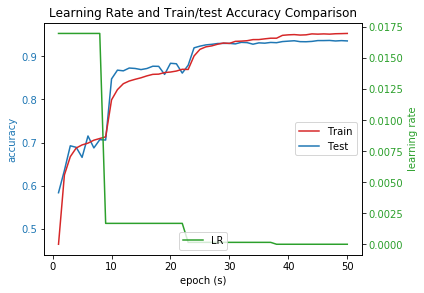

In [19]:
fig, ax1 = plt.subplots()
t = np.arange(1, 51)
color = 'tab:blue'
ax1.set_xlabel('epoch (s)')
ax1.set_ylabel('accuracy', color=color)
testline, = ax1.plot(t, model.stats().test_acc, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:red'
trainline, = ax1.plot(t, model.stats().train_acc, color=color)
ax1.legend((trainline, testline), ('Train', 'Test'), loc=7)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('learning rate', color=color)  # we already handled the x-label with ax1
lrline, = ax2.plot(t, model.stats().lr, color=color)
ax2.legend((lrline, ), ('LR',), loc=8)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Learning Rate and Train/test Accuracy Comparison")
plt.show()

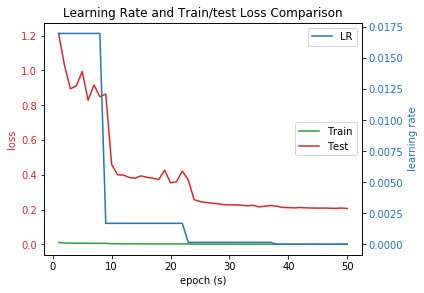

In [22]:
fig, ax1 = plt.subplots()
t = np.arange(1, 51)
color = 'tab:red'
ax1.set_xlabel('epoch (s)')
ax1.set_ylabel('loss', color=color)
testline, = ax1.plot(t, model.stats().avg_test_loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:green'
trainline, = ax1.plot(t, model.stats().avg_train_loss, color=color)
ax1.legend((trainline, testline), ('Train', 'Test'), loc=7)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)  # we already handled the x-label with ax1
lrline, = ax2.plot(t, model.stats().lr, color=color)
ax2.legend((lrline, ), ('LR',), loc=1)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Learning Rate and Train/test Loss Comparison")
plt.show()

## From above we can see that our model has achieved good amount of accuracy. There is little bit of overfitting not much which can be furthur improved by applying some more augmentations and regularization techniques.

# Applying GRADCAM.

### Printing 25 misclassified images

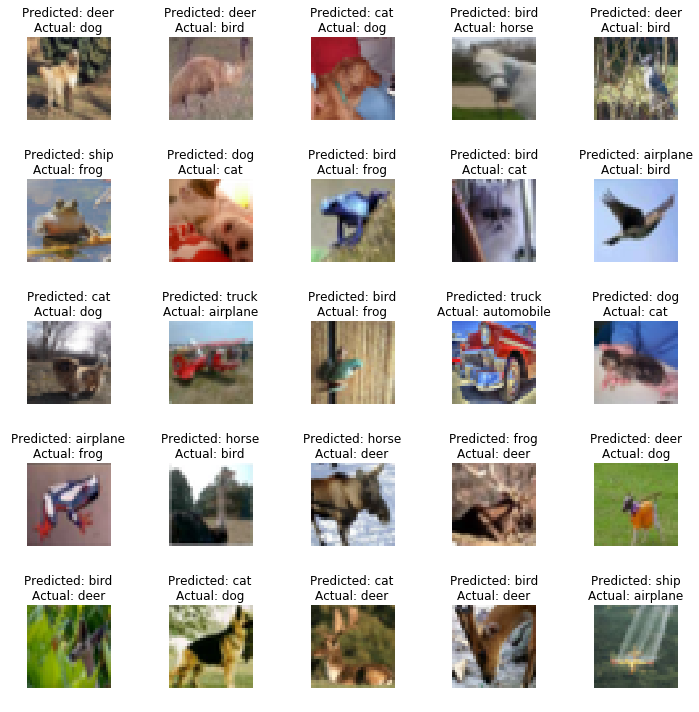

In [27]:
import plot
plot.plot_images(model.stats().get_misclassified_images(), class_names, "misclassified_imgs.png", mean=list(channel_means), std=list(channel_stdevs))

### Getting the classes of predicted images and actual images

In [28]:
mimages = model.stats().get_misclassified_images()
images = []
target_classes = []
pred_classes = []
for i in mimages:
  images.append(i["img"].cpu())
  target_classes.append(int(i['target']))
  pred_classes.append(int(i['pred']))

# Grad CAM on misclassified images (5 images at a time)

torch.Size([5, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


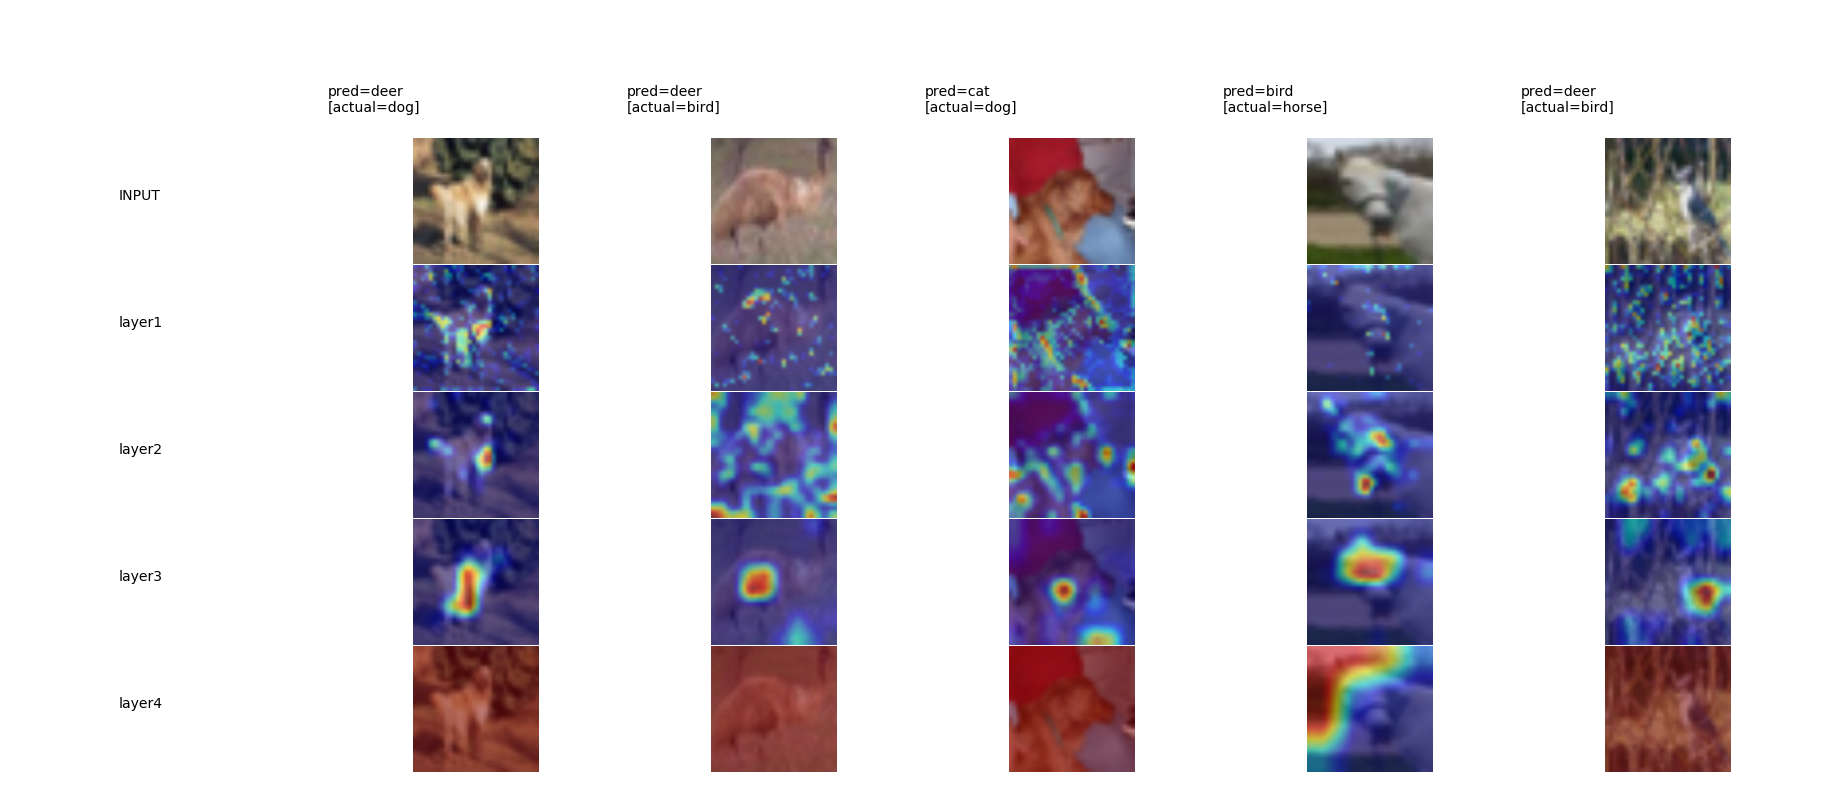

In [31]:
from GradCam_Implement import GRADCAM, PLOT
target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = GRADCAM(images[:5], target_classes[:5], model, target_layers)
PLOT(gradcam_output, images[:5], target_classes[:5], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)

torch.Size([5, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


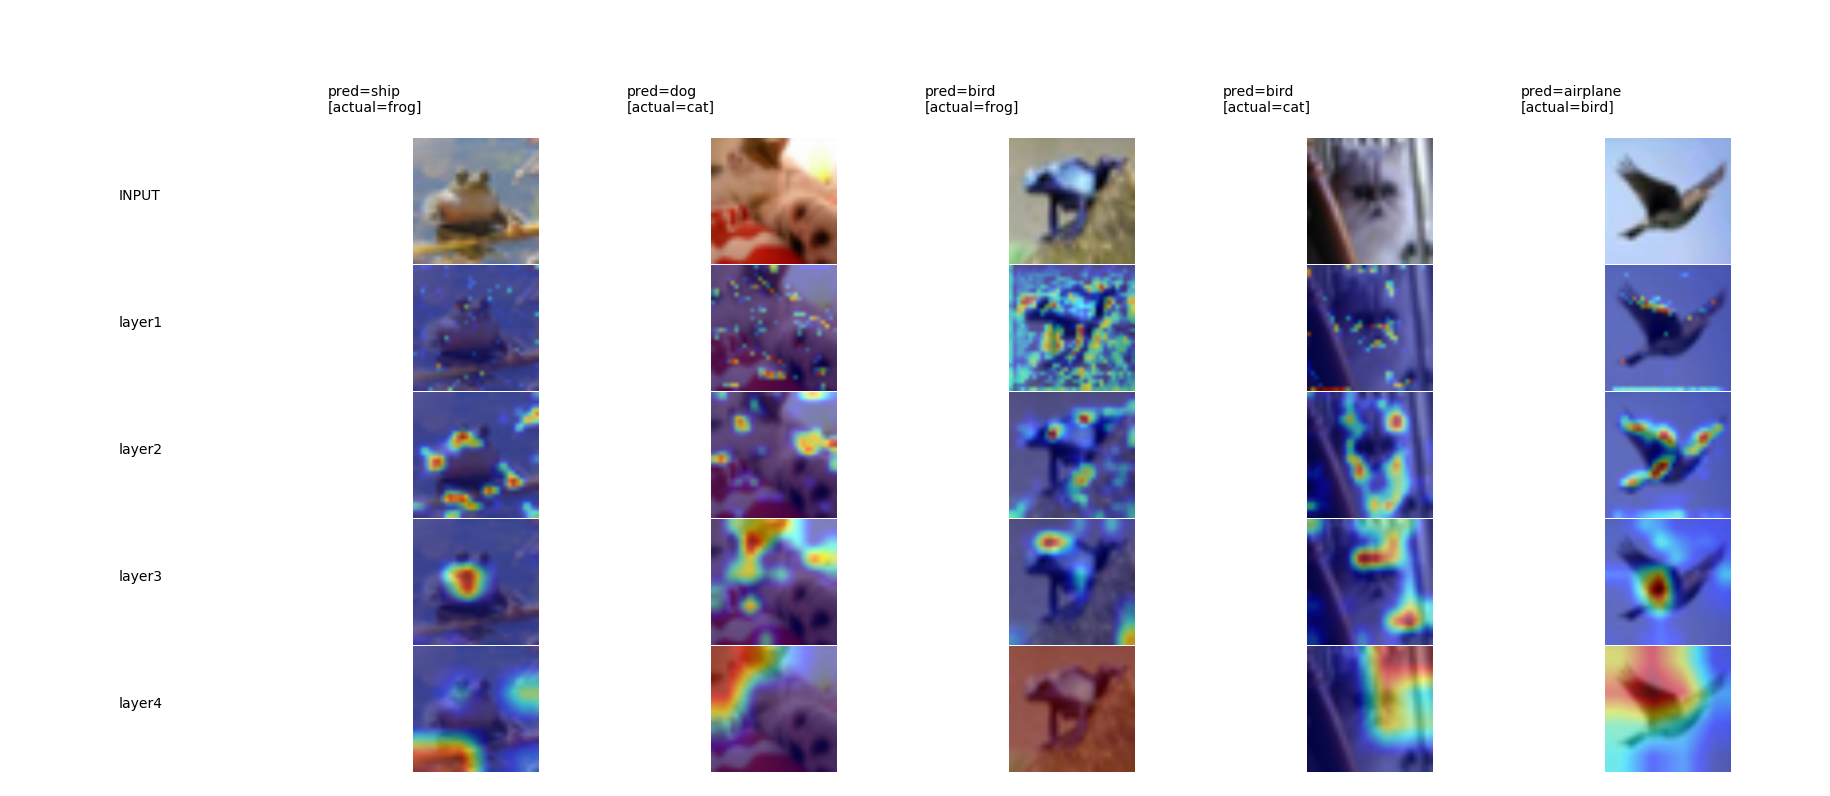

In [32]:
gradcam_output, probs, predicted_classes = GRADCAM(images[5:10], target_classes[5:10], model, target_layers)
PLOT(gradcam_output, images[5:10], target_classes[5:10], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)

torch.Size([5, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


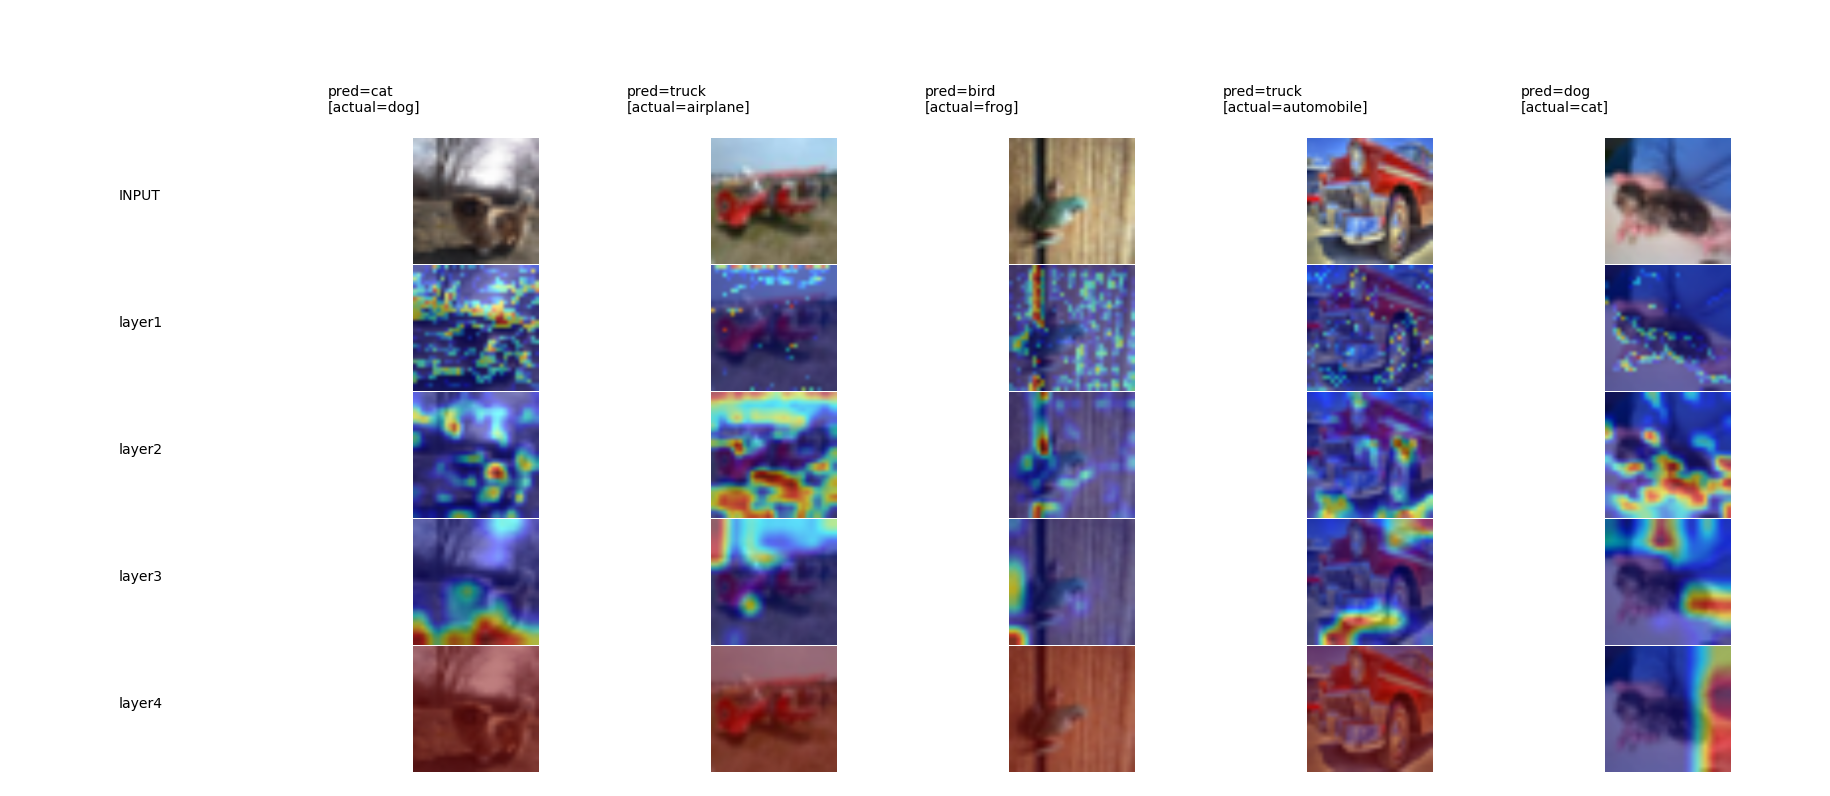

In [33]:
gradcam_output, probs, predicted_classes = GRADCAM(images[10:15], target_classes[10:15], model, target_layers)
PLOT(gradcam_output, images[10:15], target_classes[10:15], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)

torch.Size([5, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


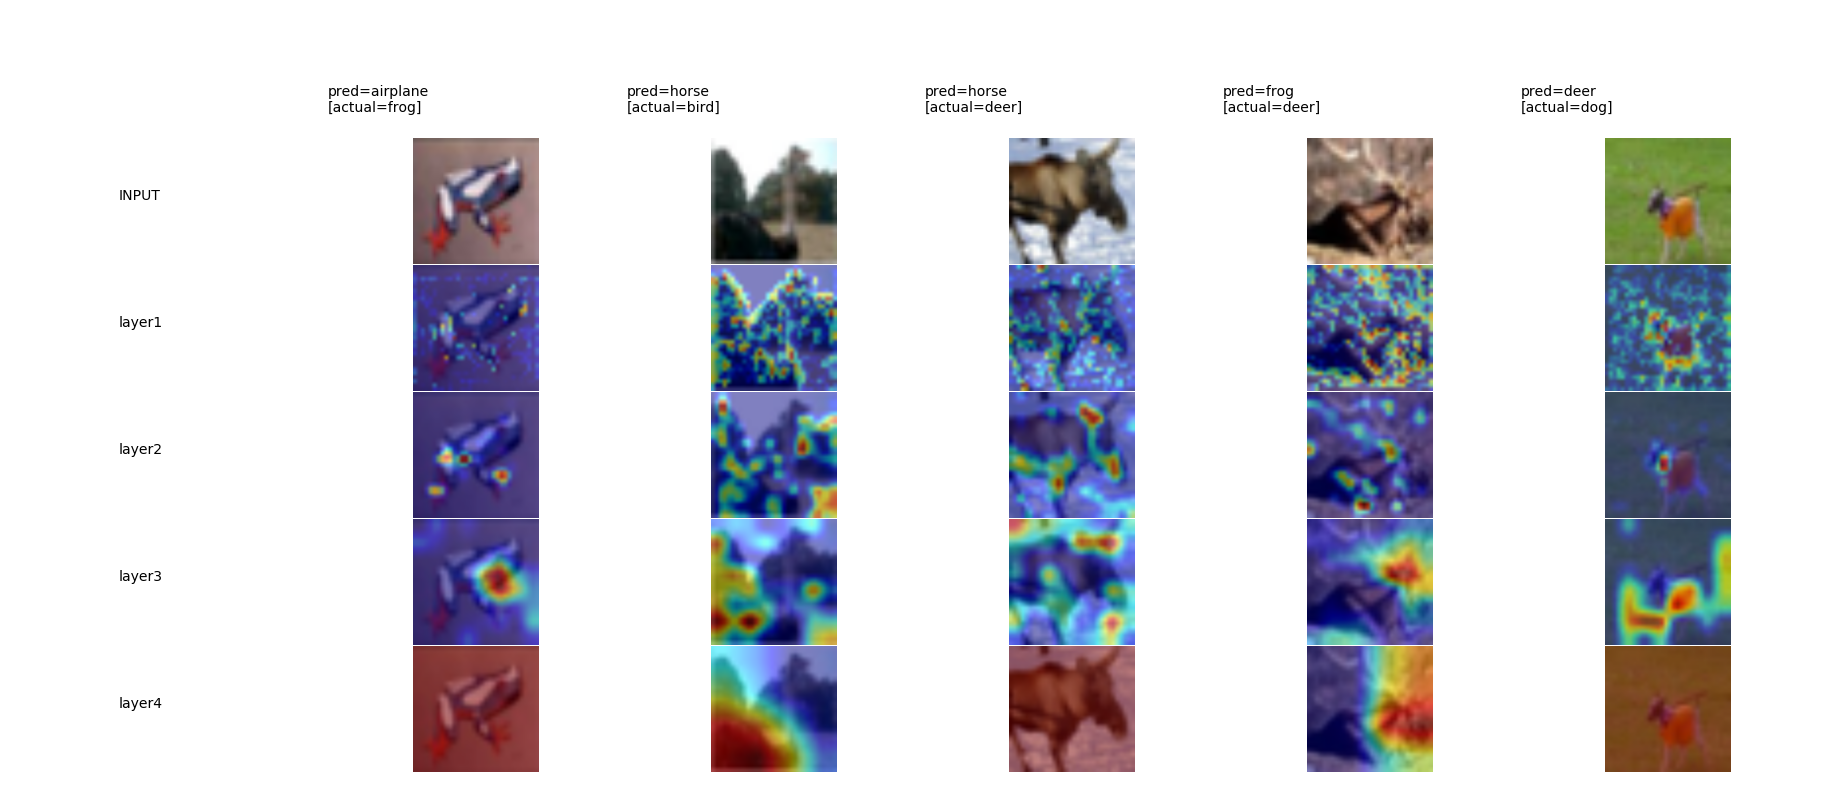

In [34]:
gradcam_output, probs, predicted_classes = GRADCAM(images[15:20], target_classes[15:20], model, target_layers)
PLOT(gradcam_output, images[15:20], target_classes[15:20], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)

torch.Size([5, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


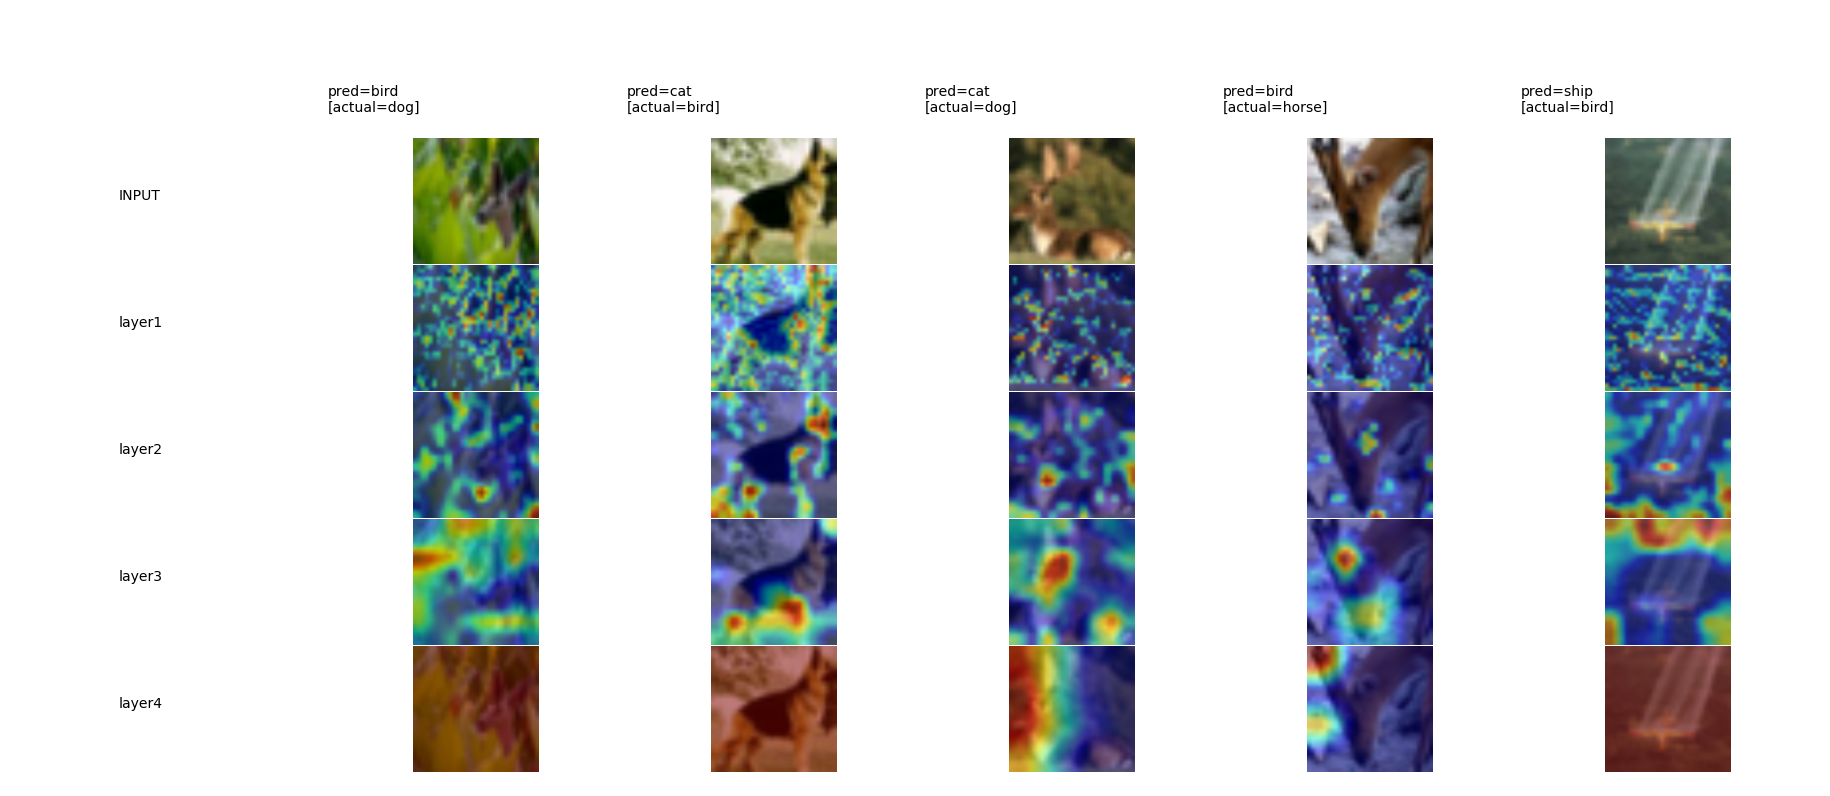

In [35]:
gradcam_output, probs, predicted_classes = GRADCAM(images[20:25], target_classes[20:25], model, target_layers)
PLOT(gradcam_output, images[20:25], target_classes[:25], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)